<a href="https://colab.research.google.com/github/Rudrabha/SS2021-19-08-2021/blob/main/Image_Super_Resolve_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

General Headers

In [2]:
import os
!pip install wget
import wget
import shutil
import glob
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


PyTorch based Headers

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch 
from torch import nn
from torch.nn import functional as F
from torch import optim

**SETTING UP THE DEVICE FOR GPU COMPUTATION**

1. Cuda : For faster computation using GPU
2. CPU : For normal computations
3. nvidia-smi : To check the GPU unit

In [4]:
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))
device = torch.device("cuda" if use_cuda else "cpu")
print("Device to be used : ",device)
!nvidia-smi

use_cuda: True
Device to be used :  cuda
Sat Aug 13 07:06:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

**Setting up Data Path**

In [5]:
#shutil.rmtree("/content/IMAGE_SUPER_RESOLVE_DATA/extracted_data")

In [6]:
#PARENT PROJECT FOLDER
parent_folder = "/content/IMAGE_SUPER_RESOLVE_DATA"

if os.path.isdir(parent_folder):
    shutil.rmtree(parent_folder)
os.mkdir(parent_folder)

#FOLDER FOR DOWNLOADING RAW DATA AND EXTRACTING IT
raw_data_folder = os.path.join(parent_folder,"raw_data")
extracted_data_folder = os.path.join(parent_folder,"extracted_data")

if not os.path.isdir(raw_data_folder):
    os.mkdir(raw_data_folder)

if not os.path.isdir(extracted_data_folder):
    os.mkdir(extracted_data_folder)
    
#PATH TO THE IMAGE FOLDER
image_data_folder = os.path.join(extracted_data_folder, "images")

**Downloading Data**

In [7]:
#DATASET LINK TO OXFORD-IIIT PET DATASET
dataset_link = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
raw_data = os.path.join(raw_data_folder, "images.tar.gz")

#DOWNLOADING THE DATA USING wget MODULE
print("Downloading Data")
wget.download(dataset_link, raw_data)
print("Downloading Done")

**Extracting the Data**

In [8]:
#EXTRACTING USING SHUTIL
shutil.unpack_archive(raw_data, extracted_data_folder)

**Function to Remove None Images**
1. I/P : Path to Image Data Folder
2. O/P : Path to all the images

In [9]:
def get_image_address(image_data_folder):
    image_address_list = []
    image_address_list = glob.glob(os.path.join(image_data_folder, "*.jpg"))
    print("Number of Files : ", len(image_address_list))
    for img_addr in image_address_list:
        try :
            img = cv2.imread(img_addr)
            x = img.shape
        except :
            image_address_list.remove(img_addr)
            os.remove(img_addr)
        
    print("Number of Files after removing : ", len(image_address_list))

    return image_address_list

**START OF TRAINING MODULE**

1. Module 1 : Data Loader
2. Module 2 : Model Creation
3. Module 3 : Training
4. Module 4 : Inference

**MODULE_1 : Data Loader**

In [10]:
class DataGenerator(Dataset):
	
    def __init__(self, image_list):
        self.files = image_list[:10]
        #ONLY 10 FILES ARE CHOSEN TO SHOW THE RESULT
        #self.files = image_list
        

    #NUMBER OF FILES IN THE DATASET
    def __len__(self):
        return len(self.files)
        

    #GETTING SINGLE PAIR OF DATA
    def __getitem__(self,idx):

        #print(files[idx])
        img = cv2.imread(self.files[idx])
        high_res_img = cv2.resize(img,(512,512))
        high_res_img = np.transpose(high_res_img, (2, 0, 1))
        low_res_img = cv2.resize(img,(64,64))
        low_res_img = cv2.resize(low_res_img, (512, 512))
        low_res_img = np.transpose(low_res_img, (2, 0, 1))
        return torch.FloatTensor(high_res_img/255.), torch.FloatTensor(low_res_img/255.)
		
	
def load_data(image_list, batch_size=32, num_workers=10, shuffle=True):

    dataset = DataGenerator(image_list)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return data_loader

**Checking the dataloader : DISPLAYING SAMPLES**

In [11]:
parent_folder = "/content/IMAGE_SUPER_RESOLVE_DATA"
extracted_data_folder = os.path.join(parent_folder, "extracted_data")
image_data_folder = os.path.join(extracted_data_folder, "images")
image_address_list = get_image_address(image_data_folder)
random.shuffle(image_address_list)

train_img_addr_list = image_address_list[:int(0.7*len(image_address_list))]
train_loader = load_data(train_img_addr_list, batch_size=1, num_workers=2, shuffle=True)
check = iter(train_loader)



Number of Files :  7390
Number of Files after removing :  7384


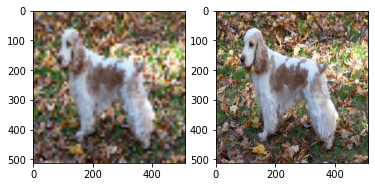

In [12]:
GT, input_img = next(check)
input_img = input_img.numpy()[0]
GT = GT.numpy()[0]

input_img = np.transpose(input_img, (1, 2, 0))
GT = np.transpose(GT, (1, 2, 0))

input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
GT = cv2.cvtColor(GT, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(input_img)
axarr[1].imshow(GT)

**MODULE 2 : Model Creation**

**Conv2D : Convolution Class with added Functionalities, like Batch Norm and Residual**

In [13]:
class Conv2d(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()
        self.residual = residual

    def forward(self, x):
        out = self.conv_block(x)
        if self.residual:
            out += x
        return self.act(out)

**Conv2D-Transpose : Transpose Convolution Class with added Functionalities, like Batch Norm and Residual**

In [14]:
class Conv2dTranspose(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, output_padding=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.ConvTranspose2d(cin, cout, kernel_size, stride, padding, output_padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

**Model : JOINING THE ABOVE CREATED BLOCKS**

Encoder Decoder Architecture

In [15]:
class Image_Super_Resolve(nn.Module):
    def __init__(self):
        super(Image_Super_Resolve, self).__init__()

        self.image_encoder = nn.Sequential(
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            Conv2d(8, 8, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(8, 8, kernel_size=3, stride=1, padding=1, residual=True),
            
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            Conv2d(16, 16, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(16, 16, kernel_size=3, stride=1, padding=1, residual=True),
            
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),      
            )
        self.image_decoder = nn.Sequential(

            # Conv2dTranspose(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),

            # Conv2dTranspose(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(3, 3, 1, 1, 0)
            )
        
    def forward(self, face_image):

        #print("Shape : ",face_image.shape)
        face_embedding = self.image_encoder(face_image)
        # print("Shape : ",face_embedding.shape)
        decoded_face = self.image_decoder(face_embedding)
        decoded_face = decoded_face + face_image

        decoded_face = torch.sigmoid(decoded_face)
        # print("Shape : ",decoded_face.shape)
        return decoded_face


**Code to check the model shape**

In [16]:
model = Image_Super_Resolve()
data = torch.rand(2, 3, 512, 512)
print(data.shape)
decoded_data = model.forward(data)
print (decoded_data.shape)

torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])


**LOSS FUNCTION : PEAK SIGNAL TO NOISE RATIO**

In [17]:
class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return 20 * torch.log10(255.0 / torch.sqrt(mse))


**MODULE 3 : Training**

**SAVE CHECKPOINT**

In [18]:
def save_ckp(checkpoint, checkpoint_path):
    torch.save(checkpoint, checkpoint_path)

**LOAD CHECKPOINT**

In [19]:
def load_ckp(checkpoint_path, model, model_opt):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model_opt.load_state_dict(checkpoint['optimizer'])
    return model, model_opt, checkpoint['epoch']

**TRAIN EPOCH**

In [20]:
def train_epoch(train_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0
    for step, (high_res_img, low_res_img) in progress_bar:
      # if high_res_img is None and low_res_img is None:
      #     continue
      model.train()
      
      #TRANSFERRING DATA TO DEVICE
      high_res_img = high_res_img.to(device)
      low_res_img = low_res_img.to(device)

      optimizer.zero_grad()

      #GETTING THE PREDICTED IMAGE
      pred_img = model.forward(low_res_img)

      #LOSS FUNCTIONS
      mse = nn.MSELoss()
      l1 = nn.L1Loss()
      psnr = PSNR()

      #CALCULATING LOSSES
      mse_loss = mse(pred_img, high_res_img)
      l1_loss = l1(pred_img, high_res_img)
      psnr_loss = psnr(pred_img*255.0, high_res_img*255.0)

      #LOSS TAKEN INTO CONSIDERATION
      loss = mse_loss
      #PSNR CAN ALSO BE TAKEN OR A LINEAR COMBINATION OF THEM

      # print(loss)

      #BACKPROPAGATING THE LOSS
      loss.backward()
      optimizer.step()

      #DISPLAYING THE LOSS
      progress_bar.set_description(
      "Epoch : {} Training Loss : {} ".format(epoch, loss))


    return model, optimizer

**VAL EPOCH**

In [21]:
def val_epoch(val_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(val_loader))
    total_loss = 0.0
    for step, (high_res_img, low_res_img) in progress_bar:

        try :
            if high_res_img is None and low_res_img is None:
                continue

            high_res_img = high_res_img.to(device)
            low_res_img = low_res_img.to(device)

            mse = nn.MSELoss()
            l1 = nn.L1Loss()
            psnr = PSNR()

            model.eval()
            pred_img = model.forward(low_res_img)

            mse_loss = mse(pred_img, high_res_img)
            l1_loss = l1(pred_img, high_res_img)
            psnr_loss = psnr(pred_img*255.0, high_res_img*255.0)

            loss = mse_loss

            progress_bar.set_description(
            "Epoch : {} Validation Loss : {} ".format(epoch-1, loss))
        except :
            continue


**TEST EPOCH**

In [22]:
def test_epoch(test_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0

    #SETTING THE NUMBER OF IMAGES TO CHECK AFTER EACH ITERATION
    no_img_to_write = 10

    #FOLDER PATH TO WRITE THE INFERENCES
    inference_folder = "/content/IMAGE_SUPER_RESOLVE_DATA/inference_data"
    if not os.path.isdir(inference_folder):
        os.mkdir(inference_folder)

    if not os.path.isdir(os.path.join(inference_folder, str(epoch))):
        os.mkdir(os.path.join(inference_folder, str(epoch)))

    for step, (high_res_img, low_res_img) in progress_bar:

        try:
            if high_res_img is None and low_res_img is None:
                continue

            high_res_img = high_res_img.to(device)
            low_res_img = low_res_img.to(device)

            mse = nn.MSELoss()
            l1 = nn.L1Loss()
            psnr = PSNR()

            model.eval()

            #PREDICTED IMAGE
            pred_img = model.forward(low_res_img)

            #mse_loss = mse(pred_img, high_res_img)
            #psnr_loss = psnr(pred_img*255.0, high_res_img*255.0)
            l1_loss = l1(pred_img, high_res_img)

            loss = l1_loss

            progress_bar.set_description(
            "Epoch : {} Test Loss : {} ".format(epoch-1, loss))

            #WRITING THE IMAGES INTO THE SPECIFIED DIRECTORY
            if(step < no_img_to_write):

                p_img = pred_img.cpu().numpy().transpose(0, 2, 3, 1) * 255
                gt_img = high_res_img.cpu().numpy().transpose(0, 2, 3, 1) * 255
                inp_img = low_res_img.cpu().numpy().transpose(0, 2, 3, 1) * 255

                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_pred.jpg"), p_img[0])
                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_gt.jpg"), gt_img[0])
                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_inp.jpg"), inp_img[0])
        except :
            continue

**Code to control the Train, Test & Val**

In [23]:
def train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume):

    #PATH TO SAVE THE CHECKPOINT
    checkpoint_path = "/content/IMAGE_SUPER_RESOLVE_DATA/checkpoint.pt"

    epoch = 0
    #IF TRAINING IS TO RESUMED FROM A CERTAIN CHECKPOINT
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while 1:
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch)
        
        #CHECKPOINT CREATION
        checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}
        
        #CHECKPOINT SAVING
        save_ckp(checkpoint, checkpoint_path)
        print("Checkpoint Saved")

        #CHECKPOINT LOADING
        model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
        print("Checkpoint Loaded")
        with torch.no_grad():
            val_epoch(val_loader, model, optimizer, epoch)
            test_epoch(test_loader, model, optimizer, epoch)

**MAIN FUNCTION**

In [24]:
def main():

    parent_folder = "/content/IMAGE_SUPER_RESOLVE_DATA"
    extracted_data_folder = os.path.join(parent_folder, "extracted_data")
    image_data_folder = os.path.join(extracted_data_folder, "images")
    image_address_list = get_image_address(image_data_folder)
    random.shuffle(image_address_list)

    train_img_addr_list = image_address_list[:int(0.7*len(image_address_list))]
    val_img_addr_list = image_address_list[len(train_img_addr_list):int(
        len(train_img_addr_list) + 0.2*len(image_address_list))]
    test_img_addr_list = image_address_list[len(
        train_img_addr_list) + len(val_img_addr_list):]

    print("Total Number of Images : ", len(image_address_list))
    print("Train : {} Val : {} Test : {}".format(
        len(train_img_addr_list), len(val_img_addr_list), len(test_img_addr_list)))

    #CREATING THE TRAIN LOADER
    train_loader = load_data(
        train_img_addr_list, batch_size=2, num_workers=2, shuffle=True)
    
    #CREATING THE VALIDATION LOADER
    val_loader = load_data(val_img_addr_list, batch_size=2,
                           num_workers=2, shuffle=True)
    
    #CREATING THE TEST LOADER
    test_loader = load_data(
        test_img_addr_list, batch_size=1, num_workers=2, shuffle=False)

    #CALLING THE MODEL
    model = Image_Super_Resolve()
    
    #UPLOADING THE MODEL TO DEVICE
    model = model.to(device)

    #DEFINING THE OPTIMIZER
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=0.01)
    
    n_epoch = 100
    
    #INDICATOR VARIABLE TO RESUME TRAINING OR START AFRESH
    resume = False
    train_val_test(train_loader, val_loader, test_loader,
                   model, optimizer, n_epoch, resume)

**CALLING THE MAIN FUNCTION**

In [25]:
main()

Number of Files :  7384
Number of Files after removing :  7384
Total Number of Images :  7384
Train : 5168 Val : 1476 Test : 740


Epoch : 0 Training Loss : 0.05349408835172653 : : 5it [00:07,  1.60s/it]


Checkpoint Saved
Checkpoint Loaded


Epoch : 0 Validation Loss : 0.06150330230593681 : : 5it [00:00, 14.07it/s]
Epoch : 0 Test Loss : 0.24310585856437683 : : 10it [00:00, 15.41it/s]
Epoch : 1 Training Loss : 0.04351840540766716 : : 5it [00:00,  6.07it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 1 Validation Loss : 0.07301818579435349 : : 5it [00:00, 13.99it/s]
Epoch : 1 Test Loss : 0.22750549018383026 : : 10it [00:00, 15.77it/s]
Epoch : 2 Training Loss : 0.022884633392095566 : : 5it [00:00,  5.87it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 2 Validation Loss : 0.04578930139541626 : : 5it [00:00, 13.54it/s]
Epoch : 2 Test Loss : 0.19305205345153809 : : 10it [00:00, 15.63it/s]
Epoch : 3 Training Loss : 0.025228559970855713 : : 5it [00:00,  6.05it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 3 Validation Loss : 0.03271336480975151 : : 5it [00:00, 13.76it/s]
Epoch : 3 Test Loss : 0.16675400733947754 : : 10it [00:00, 15.57it/s]
Epoch : 4 Training Loss : 0.010277819819748402 : : 5it [00:00,  5.92it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 4 Validation Loss : 0.038656629621982574 : : 5it [00:00, 13.51it/s]
Epoch : 4 Test Loss : 0.15599855780601501 : : 10it [00:00, 15.98it/s]
Epoch : 5 Training Loss : 0.010875208303332329 : : 5it [00:00,  5.97it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 5 Validation Loss : 0.03606855496764183 : : 5it [00:00, 13.52it/s]
Epoch : 5 Test Loss : 0.1483859121799469 : : 10it [00:00, 15.40it/s]
Epoch : 6 Training Loss : 0.012740897946059704 : : 5it [00:00,  6.06it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 6 Validation Loss : 0.02650923654437065 : : 5it [00:00, 13.14it/s]
Epoch : 6 Test Loss : 0.134552001953125 : : 10it [00:00, 15.31it/s]
Epoch : 7 Training Loss : 0.01355282124131918 : : 5it [00:00,  6.15it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 7 Validation Loss : 0.016993580386042595 : : 5it [00:00, 13.18it/s]
Epoch : 7 Test Loss : 0.1196899265050888 : : 10it [00:00, 15.90it/s]
Epoch : 8 Training Loss : 0.0125660365447402 : : 5it [00:00,  5.84it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 8 Validation Loss : 0.012227147817611694 : : 5it [00:00,  9.16it/s]
Epoch : 8 Test Loss : 0.1092831939458847 : : 10it [00:00, 10.51it/s]
Epoch : 9 Training Loss : 0.011493856087327003 : : 5it [00:00,  5.50it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 9 Validation Loss : 0.009238176047801971 : : 5it [00:00, 13.38it/s]
Epoch : 9 Test Loss : 0.105441614985466 : : 10it [00:00, 15.24it/s]
Epoch : 10 Training Loss : 0.017457621172070503 : : 5it [00:00,  5.81it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 10 Validation Loss : 0.024710243567824364 : : 5it [00:00, 13.49it/s]
Epoch : 10 Test Loss : 0.10343396663665771 : : 10it [00:00, 15.54it/s]
Epoch : 11 Training Loss : 0.02004959248006344 : : 5it [00:00,  6.06it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 11 Validation Loss : 0.01003718376159668 : : 5it [00:00, 13.82it/s]
Epoch : 11 Test Loss : 0.10783498734235764 : : 10it [00:00, 11.81it/s]
Epoch : 12 Training Loss : 0.0075098383240401745 : : 5it [00:00,  5.23it/s]


Checkpoint Saved
Checkpoint Loaded


Epoch : 12 Validation Loss : 0.010264423675835133 : : 5it [00:00, 13.42it/s]
Epoch : 12 Test Loss : 0.10488493740558624 : : 10it [00:00, 15.56it/s]
Epoch : 13 Training Loss : 0.013525774702429771 : : 5it [00:00,  5.91it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 13 Validation Loss : 0.008035136386752129 : : 5it [00:00, 13.73it/s]
Epoch : 13 Test Loss : 0.1105443686246872 : : 10it [00:00, 15.21it/s]
Epoch : 14 Training Loss : 0.012908953242003918 : : 5it [00:00,  5.90it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 14 Validation Loss : 0.0184165071696043 : : 5it [00:00, 13.64it/s]
Epoch : 14 Test Loss : 0.11443841457366943 : : 10it [00:00, 15.40it/s]
Epoch : 15 Training Loss : 0.010484853759407997 : : 5it [00:00,  5.96it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 15 Validation Loss : 0.015068355947732925 : : 5it [00:00, 13.55it/s]
Epoch : 15 Test Loss : 0.10154344886541367 : : 10it [00:00, 15.84it/s]
Epoch : 16 Training Loss : 0.011298296973109245 : : 5it [00:00,  5.85it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 16 Validation Loss : 0.008843143470585346 : : 5it [00:00, 13.96it/s]
Epoch : 16 Test Loss : 0.09964774549007416 : : 10it [00:00, 15.86it/s]
Epoch : 17 Training Loss : 0.007074497640132904 : : 5it [00:00,  6.06it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 17 Validation Loss : 0.015970047563314438 : : 5it [00:00, 13.06it/s]
Epoch : 17 Test Loss : 0.10137125104665756 : : 10it [00:00, 15.29it/s]
Epoch : 18 Training Loss : 0.018591787666082382 : : 5it [00:00,  5.88it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 18 Validation Loss : 0.01564606837928295 : : 5it [00:00, 13.35it/s]
Epoch : 18 Test Loss : 0.10324083268642426 : : 10it [00:00, 15.00it/s]
Epoch : 19 Training Loss : 0.006083378568291664 : : 5it [00:00,  6.04it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 19 Validation Loss : 0.008938285522162914 : : 5it [00:00, 13.37it/s]
Epoch : 19 Test Loss : 0.09810423105955124 : : 10it [00:00, 15.42it/s]
Epoch : 20 Training Loss : 0.006639477796852589 : : 5it [00:00,  5.89it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 20 Validation Loss : 0.005746056791394949 : : 5it [00:00, 13.01it/s]
Epoch : 20 Test Loss : 0.09621135890483856 : : 10it [00:00, 15.67it/s]
Epoch : 21 Training Loss : 0.012161940336227417 : : 5it [00:00,  6.00it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 21 Validation Loss : 0.005760402884334326 : : 5it [00:00, 13.03it/s]
Epoch : 21 Test Loss : 0.09860005229711533 : : 10it [00:00, 15.34it/s]
Epoch : 22 Training Loss : 0.01960880123078823 : : 5it [00:00,  6.00it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 22 Validation Loss : 0.019460614770650864 : : 5it [00:00, 13.07it/s]
Epoch : 22 Test Loss : 0.09665060043334961 : : 10it [00:00, 10.14it/s]
Epoch : 23 Training Loss : 0.007308415602892637 : : 5it [00:01,  4.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 23 Validation Loss : 0.006440901197493076 : : 5it [00:00, 13.12it/s]
Epoch : 23 Test Loss : 0.09462615847587585 : : 10it [00:00, 15.31it/s]
Epoch : 24 Training Loss : 0.007751006167382002 : : 5it [00:00,  5.98it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 24 Validation Loss : 0.010406134650111198 : : 5it [00:00, 13.25it/s]
Epoch : 24 Test Loss : 0.10245557874441147 : : 10it [00:01,  7.86it/s]
Epoch : 25 Training Loss : 0.005770822521299124 : : 5it [00:01,  4.72it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 25 Validation Loss : 0.020259274169802666 : : 5it [00:00, 13.38it/s]
Epoch : 25 Test Loss : 0.09507058560848236 : : 10it [00:00, 15.61it/s]
Epoch : 26 Training Loss : 0.009868822060525417 : : 5it [00:00,  5.95it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 26 Validation Loss : 0.011645614169538021 : : 5it [00:00, 13.12it/s]
Epoch : 26 Test Loss : 0.09073671698570251 : : 10it [00:00, 15.38it/s]
Epoch : 27 Training Loss : 0.017889797687530518 : : 5it [00:00,  5.93it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 27 Validation Loss : 0.017255540937185287 : : 5it [00:00, 13.08it/s]
Epoch : 27 Test Loss : 0.09200918674468994 : : 10it [00:00, 15.11it/s]
Epoch : 28 Training Loss : 0.007609429769217968 : : 5it [00:00,  5.90it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 28 Validation Loss : 0.0105891777202487 : : 5it [00:00, 13.05it/s]
Epoch : 28 Test Loss : 0.091663658618927 : : 10it [00:00, 15.36it/s]
Epoch : 29 Training Loss : 0.010886753909289837 : : 5it [00:00,  5.92it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 29 Validation Loss : 0.00952041707932949 : : 5it [00:00, 13.50it/s]
Epoch : 29 Test Loss : 0.09011907875537872 : : 10it [00:00, 15.19it/s]
Epoch : 30 Training Loss : 0.01715913414955139 : : 5it [00:00,  5.90it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 30 Validation Loss : 0.01632767543196678 : : 5it [00:00, 13.38it/s]
Epoch : 30 Test Loss : 0.09273239225149155 : : 10it [00:00, 14.92it/s]
Epoch : 31 Training Loss : 0.007352541666477919 : : 5it [00:00,  5.86it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 31 Validation Loss : 0.0072537986561656 : : 5it [00:00, 13.12it/s]
Epoch : 31 Test Loss : 0.09724098443984985 : : 10it [00:00, 15.48it/s]
Epoch : 32 Training Loss : 0.008730514906346798 : : 5it [00:00,  5.86it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 32 Validation Loss : 0.006998238619416952 : : 5it [00:00, 13.19it/s]
Epoch : 32 Test Loss : 0.08795483410358429 : : 10it [00:00, 15.41it/s]
Epoch : 33 Training Loss : 0.007552105467766523 : : 5it [00:00,  5.88it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 33 Validation Loss : 0.010105057619512081 : : 5it [00:00, 13.19it/s]
Epoch : 33 Test Loss : 0.0877147763967514 : : 10it [00:00, 15.12it/s]
Epoch : 34 Training Loss : 0.005568183958530426 : : 5it [00:00,  5.90it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 34 Validation Loss : 0.0071010710671544075 : : 5it [00:00, 12.94it/s]
Epoch : 34 Test Loss : 0.08412914723157883 : : 10it [00:00, 15.28it/s]
Epoch : 35 Training Loss : 0.006550543010234833 : : 5it [00:00,  5.77it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 35 Validation Loss : 0.006680810824036598 : : 5it [00:00, 13.30it/s]
Epoch : 35 Test Loss : 0.0850248783826828 : : 10it [00:00, 15.14it/s]
Epoch : 36 Training Loss : 0.005279547534883022 : : 5it [00:00,  5.85it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 36 Validation Loss : 0.00706552853807807 : : 5it [00:00, 13.41it/s]
Epoch : 36 Test Loss : 0.08456521481275558 : : 10it [00:00, 15.09it/s]
Epoch : 37 Training Loss : 0.005314468406140804 : : 5it [00:00,  5.90it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 37 Validation Loss : 0.013263199478387833 : : 5it [00:00, 13.31it/s]
Epoch : 37 Test Loss : 0.08508067578077316 : : 10it [00:00, 15.44it/s]
Epoch : 38 Training Loss : 0.008933017030358315 : : 5it [00:00,  5.89it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 38 Validation Loss : 0.008778429590165615 : : 5it [00:00, 13.16it/s]
Epoch : 38 Test Loss : 0.08373972773551941 : : 10it [00:00, 15.44it/s]
Epoch : 39 Training Loss : 0.007443711161613464 : : 5it [00:00,  5.73it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 39 Validation Loss : 0.011105068027973175 : : 5it [00:00, 13.13it/s]
Epoch : 39 Test Loss : 0.08232653886079788 : : 10it [00:00, 15.54it/s]
Epoch : 40 Training Loss : 0.005528472363948822 : : 5it [00:00,  5.75it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 40 Validation Loss : 0.0070428019389510155 : : 5it [00:00, 13.06it/s]
Epoch : 40 Test Loss : 0.08708953112363815 : : 10it [00:00, 15.02it/s]
Epoch : 41 Training Loss : 0.013775917701423168 : : 5it [00:00,  5.88it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 41 Validation Loss : 0.009330951608717442 : : 5it [00:00, 13.39it/s]
Epoch : 41 Test Loss : 0.09215684980154037 : : 10it [00:00, 14.80it/s]
Epoch : 42 Training Loss : 0.009051571600139141 : : 5it [00:00,  5.80it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 42 Validation Loss : 0.004571465775370598 : : 5it [00:00, 13.28it/s]
Epoch : 42 Test Loss : 0.08098863810300827 : : 10it [00:00, 15.31it/s]
Epoch : 43 Training Loss : 0.006119445897638798 : : 5it [00:00,  5.88it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 43 Validation Loss : 0.010015013627707958 : : 5it [00:00, 13.03it/s]
Epoch : 43 Test Loss : 0.08598420023918152 : : 10it [00:00, 15.18it/s]
Epoch : 44 Training Loss : 0.0056614442728459835 : : 5it [00:00,  5.88it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 44 Validation Loss : 0.011938522569835186 : : 5it [00:00, 12.71it/s]
Epoch : 44 Test Loss : 0.0813661739230156 : : 10it [00:00, 15.45it/s]
Epoch : 45 Training Loss : 0.006028033792972565 : : 5it [00:00,  5.88it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 45 Validation Loss : 0.006780534982681274 : : 5it [00:00, 13.76it/s]
Epoch : 45 Test Loss : 0.0835447758436203 : : 10it [00:00, 15.70it/s]
Epoch : 46 Training Loss : 0.00405897106975317 : : 5it [00:00,  5.91it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 46 Validation Loss : 0.00859585590660572 : : 5it [00:00, 12.95it/s]
Epoch : 46 Test Loss : 0.07989811152219772 : : 10it [00:00, 15.27it/s]
Epoch : 47 Training Loss : 0.007729440927505493 : : 5it [00:00,  5.84it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 47 Validation Loss : 0.005051807966083288 : : 5it [00:00, 13.20it/s]
Epoch : 47 Test Loss : 0.08450347185134888 : : 10it [00:00, 15.31it/s]
Epoch : 48 Training Loss : 0.007372360210865736 : : 5it [00:00,  5.80it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 48 Validation Loss : 0.006169514264911413 : : 5it [00:00, 13.27it/s]
Epoch : 48 Test Loss : 0.0789693146944046 : : 10it [00:00, 15.13it/s]
Epoch : 49 Training Loss : 0.005870449356734753 : : 5it [00:00,  5.84it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 49 Validation Loss : 0.012490875087678432 : : 5it [00:00, 12.60it/s]
Epoch : 49 Test Loss : 0.08526159822940826 : : 10it [00:00, 15.47it/s]
Epoch : 50 Training Loss : 0.00653553381562233 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 50 Validation Loss : 0.010190514847636223 : : 5it [00:00,  9.06it/s]
Epoch : 50 Test Loss : 0.08410505950450897 : : 10it [00:00, 10.05it/s]
Epoch : 51 Training Loss : 0.005551283713430166 : : 5it [00:00,  5.43it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 51 Validation Loss : 0.01213563047349453 : : 5it [00:00, 13.21it/s]
Epoch : 51 Test Loss : 0.08651112020015717 : : 10it [00:00, 15.62it/s]
Epoch : 52 Training Loss : 0.007967653684318066 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 52 Validation Loss : 0.007177030202001333 : : 5it [00:00, 12.79it/s]
Epoch : 52 Test Loss : 0.0799420177936554 : : 10it [00:00, 15.49it/s]
Epoch : 53 Training Loss : 0.004585165064781904 : : 5it [00:00,  5.69it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 53 Validation Loss : 0.007433773018419743 : : 5it [00:00, 13.35it/s]
Epoch : 53 Test Loss : 0.08032484352588654 : : 10it [00:00, 15.05it/s]
Epoch : 54 Training Loss : 0.00759043637663126 : : 5it [00:00,  5.74it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 54 Validation Loss : 0.004103619605302811 : : 5it [00:00, 13.17it/s]
Epoch : 54 Test Loss : 0.07709429413080215 : : 10it [00:00, 15.21it/s]
Epoch : 55 Training Loss : 0.012396901845932007 : : 5it [00:00,  5.78it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 55 Validation Loss : 0.01317102462053299 : : 5it [00:00, 13.20it/s]
Epoch : 55 Test Loss : 0.08173780143260956 : : 10it [00:00, 15.60it/s]
Epoch : 56 Training Loss : 0.0075167506001889706 : : 5it [00:00,  5.86it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 56 Validation Loss : 0.006392087787389755 : : 5it [00:00, 13.39it/s]
Epoch : 56 Test Loss : 0.08751805126667023 : : 10it [00:00, 15.11it/s]
Epoch : 57 Training Loss : 0.009298320859670639 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 57 Validation Loss : 0.00807624775916338 : : 5it [00:00, 13.14it/s]
Epoch : 57 Test Loss : 0.07936996966600418 : : 10it [00:00, 15.44it/s]
Epoch : 58 Training Loss : 0.007831742987036705 : : 5it [00:00,  5.70it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 58 Validation Loss : 0.006864625494927168 : : 5it [00:00, 13.99it/s]
Epoch : 58 Test Loss : 0.08038204163312912 : : 10it [00:00, 15.37it/s]
Epoch : 59 Training Loss : 0.005686509422957897 : : 5it [00:00,  5.73it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 59 Validation Loss : 0.008353978395462036 : : 5it [00:00, 13.17it/s]
Epoch : 59 Test Loss : 0.08382861316204071 : : 10it [00:00, 15.01it/s]
Epoch : 60 Training Loss : 0.006686490960419178 : : 5it [00:00,  5.79it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 60 Validation Loss : 0.009350322186946869 : : 5it [00:00, 13.43it/s]
Epoch : 60 Test Loss : 0.07995583117008209 : : 10it [00:00, 15.02it/s]
Epoch : 61 Training Loss : 0.006079628132283688 : : 5it [00:00,  5.76it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 61 Validation Loss : 0.0103772496804595 : : 5it [00:00, 13.57it/s]
Epoch : 61 Test Loss : 0.0795162096619606 : : 10it [00:00, 15.20it/s]
Epoch : 62 Training Loss : 0.005124839022755623 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 62 Validation Loss : 0.00872199609875679 : : 5it [00:00, 12.83it/s]
Epoch : 62 Test Loss : 0.08465933799743652 : : 10it [00:00, 15.07it/s]
Epoch : 63 Training Loss : 0.005610434338450432 : : 5it [00:00,  5.74it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 63 Validation Loss : 0.006448357366025448 : : 5it [00:00, 13.05it/s]
Epoch : 63 Test Loss : 0.080813467502594 : : 10it [00:00, 15.03it/s]
Epoch : 64 Training Loss : 0.0067884973250329494 : : 5it [00:00,  5.76it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 64 Validation Loss : 0.005268457345664501 : : 5it [00:00, 13.33it/s]
Epoch : 64 Test Loss : 0.07993815839290619 : : 10it [00:00, 15.28it/s]
Epoch : 65 Training Loss : 0.0075836824253201485 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 65 Validation Loss : 0.0051247430965304375 : : 5it [00:00, 13.23it/s]
Epoch : 65 Test Loss : 0.08043582737445831 : : 10it [00:00, 14.93it/s]
Epoch : 66 Training Loss : 0.0077937874011695385 : : 5it [00:00,  5.73it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 66 Validation Loss : 0.0072896527126431465 : : 5it [00:00, 13.00it/s]
Epoch : 66 Test Loss : 0.07743042707443237 : : 10it [00:00, 15.20it/s]
Epoch : 67 Training Loss : 0.010576460510492325 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 67 Validation Loss : 0.006626779213547707 : : 5it [00:00, 12.88it/s]
Epoch : 67 Test Loss : 0.08342385292053223 : : 10it [00:00, 15.37it/s]
Epoch : 68 Training Loss : 0.00871228240430355 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 68 Validation Loss : 0.006288645323365927 : : 5it [00:00, 12.91it/s]
Epoch : 68 Test Loss : 0.08590125292539597 : : 10it [00:00, 15.03it/s]
Epoch : 69 Training Loss : 0.006986075546592474 : : 5it [00:00,  5.75it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 69 Validation Loss : 0.005042199045419693 : : 5it [00:00, 13.08it/s]
Epoch : 69 Test Loss : 0.08388741314411163 : : 10it [00:00, 15.05it/s]
Epoch : 70 Training Loss : 0.0055865636095404625 : : 5it [00:00,  5.73it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 70 Validation Loss : 0.015926506370306015 : : 5it [00:00, 13.09it/s]
Epoch : 70 Test Loss : 0.07820690423250198 : : 10it [00:00, 15.70it/s]
Epoch : 71 Training Loss : 0.004823998082429171 : : 5it [00:00,  5.70it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 71 Validation Loss : 0.014919005334377289 : : 5it [00:00, 13.29it/s]
Epoch : 71 Test Loss : 0.0831003487110138 : : 10it [00:00, 15.32it/s]
Epoch : 72 Training Loss : 0.004518411587923765 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 72 Validation Loss : 0.015644196420907974 : : 5it [00:00, 12.01it/s]
Epoch : 72 Test Loss : 0.08033784478902817 : : 10it [00:00, 15.19it/s]
Epoch : 73 Training Loss : 0.010514670982956886 : : 5it [00:00,  5.69it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 73 Validation Loss : 0.011123868636786938 : : 5it [00:00, 13.43it/s]
Epoch : 73 Test Loss : 0.09018366038799286 : : 10it [00:00, 15.25it/s]
Epoch : 74 Training Loss : 0.007460122928023338 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 74 Validation Loss : 0.007308808621019125 : : 5it [00:00, 12.80it/s]
Epoch : 74 Test Loss : 0.09046971797943115 : : 10it [00:00, 15.12it/s]
Epoch : 75 Training Loss : 0.004119285382330418 : : 5it [00:00,  5.71it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 75 Validation Loss : 0.012298999354243279 : : 5it [00:00, 12.95it/s]
Epoch : 75 Test Loss : 0.10180884599685669 : : 10it [00:00, 15.20it/s]
Epoch : 76 Training Loss : 0.004620068706572056 : : 5it [00:00,  5.72it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 76 Validation Loss : 0.005452297627925873 : : 5it [00:00, 12.74it/s]
Epoch : 76 Test Loss : 0.0968443900346756 : : 10it [00:00, 15.06it/s]
Epoch : 77 Training Loss : 0.005167335271835327 : : 5it [00:00,  5.78it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 77 Validation Loss : 0.005420138593763113 : : 5it [00:00, 13.24it/s]
Epoch : 77 Test Loss : 0.09970484673976898 : : 10it [00:00, 15.59it/s]
Epoch : 78 Training Loss : 0.013882704079151154 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 78 Validation Loss : 0.0050844354555010796 : : 5it [00:00, 13.02it/s]
Epoch : 78 Test Loss : 0.0850948840379715 : : 10it [00:00, 14.83it/s]
Epoch : 79 Training Loss : 0.0072190603241324425 : : 5it [00:00,  5.70it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 79 Validation Loss : 0.009798584505915642 : : 5it [00:00, 12.88it/s]
Epoch : 79 Test Loss : 0.09915308654308319 : : 10it [00:00, 14.76it/s]
Epoch : 80 Training Loss : 0.006951513700187206 : : 5it [00:00,  5.72it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 80 Validation Loss : 0.01338996272534132 : : 5it [00:00, 13.32it/s]
Epoch : 80 Test Loss : 0.11110211908817291 : : 10it [00:00, 15.36it/s]
Epoch : 81 Training Loss : 0.0066030933521687984 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 81 Validation Loss : 0.005080222152173519 : : 5it [00:00, 12.64it/s]
Epoch : 81 Test Loss : 0.09345950931310654 : : 10it [00:00, 15.00it/s]
Epoch : 82 Training Loss : 0.007037521339952946 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 82 Validation Loss : 0.004610566888004541 : : 5it [00:00, 13.06it/s]
Epoch : 82 Test Loss : 0.09350931644439697 : : 10it [00:00, 14.98it/s]
Epoch : 83 Training Loss : 0.004795067012310028 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 83 Validation Loss : 0.00880340300500393 : : 5it [00:00, 13.26it/s]
Epoch : 83 Test Loss : 0.08937712758779526 : : 10it [00:00, 14.96it/s]
Epoch : 84 Training Loss : 0.008145383559167385 : : 5it [00:00,  5.70it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 84 Validation Loss : 0.006584229879081249 : : 5it [00:00, 12.93it/s]
Epoch : 84 Test Loss : 0.08299144357442856 : : 10it [00:00, 15.24it/s]
Epoch : 85 Training Loss : 0.00375397689640522 : : 5it [00:00,  5.71it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 85 Validation Loss : 0.004269903525710106 : : 5it [00:00, 12.81it/s]
Epoch : 85 Test Loss : 0.08587323129177094 : : 10it [00:00, 15.26it/s]
Epoch : 86 Training Loss : 0.006678308360278606 : : 5it [00:00,  5.70it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 86 Validation Loss : 0.00429084338247776 : : 5it [00:00, 12.93it/s]
Epoch : 86 Test Loss : 0.08442040532827377 : : 10it [00:00, 15.28it/s]
Epoch : 87 Training Loss : 0.007363279350101948 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 87 Validation Loss : 0.01250988058745861 : : 5it [00:00, 13.33it/s]
Epoch : 87 Test Loss : 0.07596249878406525 : : 10it [00:00, 15.25it/s]
Epoch : 88 Training Loss : 0.007666854187846184 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 88 Validation Loss : 0.006153306923806667 : : 5it [00:00, 13.35it/s]
Epoch : 88 Test Loss : 0.08241735398769379 : : 10it [00:00, 15.08it/s]
Epoch : 89 Training Loss : 0.008148141205310822 : : 5it [00:00,  5.86it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 89 Validation Loss : 0.006523802410811186 : : 5it [00:00, 12.83it/s]
Epoch : 89 Test Loss : 0.08293726295232773 : : 10it [00:00, 15.20it/s]
Epoch : 90 Training Loss : 0.0056279925629496574 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 90 Validation Loss : 0.011188140138983727 : : 5it [00:00, 12.67it/s]
Epoch : 90 Test Loss : 0.07947167009115219 : : 10it [00:00, 14.70it/s]
Epoch : 91 Training Loss : 0.008041217923164368 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 91 Validation Loss : 0.008755376562476158 : : 5it [00:00, 12.94it/s]
Epoch : 91 Test Loss : 0.07990407198667526 : : 10it [00:00, 15.22it/s]
Epoch : 92 Training Loss : 0.00711093982681632 : : 5it [00:00,  5.43it/s]


Checkpoint Saved
Checkpoint Loaded


Epoch : 92 Validation Loss : 0.008417095057666302 : : 5it [00:00,  9.38it/s]
Epoch : 92 Test Loss : 0.07951031625270844 : : 10it [00:00, 10.15it/s]
Epoch : 93 Training Loss : 0.005252411123365164 : : 5it [00:00,  5.50it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 93 Validation Loss : 0.007858885452151299 : : 5it [00:00, 12.82it/s]
Epoch : 93 Test Loss : 0.0813397467136383 : : 10it [00:00, 15.23it/s]
Epoch : 94 Training Loss : 0.011480122804641724 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 94 Validation Loss : 0.011172175407409668 : : 5it [00:00, 13.61it/s]
Epoch : 94 Test Loss : 0.0811377465724945 : : 10it [00:00, 15.34it/s]
Epoch : 95 Training Loss : 0.009085336700081825 : : 5it [00:00,  5.70it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 95 Validation Loss : 0.00850797351449728 : : 5it [00:00, 12.93it/s]
Epoch : 95 Test Loss : 0.09081964939832687 : : 10it [00:00, 15.20it/s]
Epoch : 96 Training Loss : 0.0072193630039691925 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 96 Validation Loss : 0.008635293692350388 : : 5it [00:00, 12.70it/s]
Epoch : 96 Test Loss : 0.08375513553619385 : : 10it [00:00, 14.87it/s]
Epoch : 97 Training Loss : 0.00562489777803421 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 97 Validation Loss : 0.01122986525297165 : : 5it [00:00, 13.44it/s]
Epoch : 97 Test Loss : 0.07641726732254028 : : 10it [00:00, 14.89it/s]
Epoch : 98 Training Loss : 0.004952706396579742 : : 5it [00:00,  5.69it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 98 Validation Loss : 0.006725857965648174 : : 5it [00:00, 13.00it/s]
Epoch : 98 Test Loss : 0.07842551916837692 : : 10it [00:00, 14.75it/s]
Epoch : 99 Training Loss : 0.0077216895297169685 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 99 Validation Loss : 0.006812679581344128 : : 5it [00:00, 12.71it/s]
Epoch : 99 Test Loss : 0.0909159928560257 : : 10it [00:00, 14.99it/s]
Epoch : 100 Training Loss : 0.005221258848905563 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 100 Validation Loss : 0.0038358725141733885 : : 5it [00:00, 12.58it/s]
Epoch : 100 Test Loss : 0.07898657768964767 : : 10it [00:00, 15.04it/s]
Epoch : 101 Training Loss : 0.003239457029849291 : : 5it [00:00,  5.77it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 101 Validation Loss : 0.005728845484554768 : : 5it [00:00, 12.88it/s]
Epoch : 101 Test Loss : 0.09132468700408936 : : 10it [00:00, 15.31it/s]
Epoch : 102 Training Loss : 0.013061131350696087 : : 5it [00:00,  5.71it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 102 Validation Loss : 0.00913122296333313 : : 5it [00:00, 12.95it/s]
Epoch : 102 Test Loss : 0.0805574357509613 : : 10it [00:00, 14.66it/s]
Epoch : 103 Training Loss : 0.004054447170346975 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 103 Validation Loss : 0.005796290002763271 : : 5it [00:00, 12.79it/s]
Epoch : 103 Test Loss : 0.0945277139544487 : : 10it [00:00, 14.96it/s]
Epoch : 104 Training Loss : 0.004983366467058659 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 104 Validation Loss : 0.00863590557128191 : : 5it [00:00, 12.88it/s]
Epoch : 104 Test Loss : 0.09092730283737183 : : 10it [00:00, 15.40it/s]
Epoch : 105 Training Loss : 0.0034315120428800583 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 105 Validation Loss : 0.008338305167853832 : : 5it [00:00, 13.35it/s]
Epoch : 105 Test Loss : 0.08751267194747925 : : 10it [00:00, 14.82it/s]
Epoch : 106 Training Loss : 0.0052275508642196655 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 106 Validation Loss : 0.009896565228700638 : : 5it [00:00, 13.66it/s]
Epoch : 106 Test Loss : 0.08357759565114975 : : 10it [00:00, 15.07it/s]
Epoch : 107 Training Loss : 0.0032724691554903984 : : 5it [00:00,  5.71it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 107 Validation Loss : 0.007247329689562321 : : 5it [00:00, 13.18it/s]
Epoch : 107 Test Loss : 0.07828618586063385 : : 10it [00:00, 14.55it/s]
Epoch : 108 Training Loss : 0.004946357570588589 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 108 Validation Loss : 0.003490779548883438 : : 5it [00:00, 13.02it/s]
Epoch : 108 Test Loss : 0.08345633000135422 : : 10it [00:00, 15.12it/s]
Epoch : 109 Training Loss : 0.003578370437026024 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 109 Validation Loss : 0.008389012888073921 : : 5it [00:00, 13.23it/s]
Epoch : 109 Test Loss : 0.07883002609014511 : : 10it [00:00, 15.29it/s]
Epoch : 110 Training Loss : 0.007878878153860569 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 110 Validation Loss : 0.00662478432059288 : : 5it [00:00, 12.77it/s]
Epoch : 110 Test Loss : 0.0817316323518753 : : 10it [00:00, 14.88it/s]
Epoch : 111 Training Loss : 0.0060794902965426445 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 111 Validation Loss : 0.005495233461260796 : : 5it [00:00, 13.43it/s]
Epoch : 111 Test Loss : 0.0810428187251091 : : 10it [00:00, 15.08it/s]
Epoch : 112 Training Loss : 0.006524505093693733 : : 5it [00:00,  5.76it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 112 Validation Loss : 0.0068821064196527 : : 5it [00:00, 13.18it/s]
Epoch : 112 Test Loss : 0.07661449164152145 : : 10it [00:00, 14.83it/s]
Epoch : 113 Training Loss : 0.004584446549415588 : : 5it [00:00,  5.73it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 113 Validation Loss : 0.01136816293001175 : : 5it [00:00, 13.14it/s]
Epoch : 113 Test Loss : 0.08114287257194519 : : 10it [00:00, 15.15it/s]
Epoch : 114 Training Loss : 0.006296904757618904 : : 5it [00:00,  5.79it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 114 Validation Loss : 0.010871944949030876 : : 5it [00:00, 12.92it/s]
Epoch : 114 Test Loss : 0.07679226994514465 : : 10it [00:00, 14.86it/s]
Epoch : 115 Training Loss : 0.006007800810039043 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 115 Validation Loss : 0.011299761943519115 : : 5it [00:00, 13.03it/s]
Epoch : 115 Test Loss : 0.08478467166423798 : : 10it [00:00, 14.68it/s]
Epoch : 116 Training Loss : 0.00447597773745656 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 116 Validation Loss : 0.0056425826624035835 : : 5it [00:00, 13.43it/s]
Epoch : 116 Test Loss : 0.08132145553827286 : : 10it [00:00, 15.18it/s]
Epoch : 117 Training Loss : 0.0042176032438874245 : : 5it [00:00,  5.72it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 117 Validation Loss : 0.013178832828998566 : : 5it [00:00, 12.61it/s]
Epoch : 117 Test Loss : 0.08179809898138046 : : 10it [00:00, 15.35it/s]
Epoch : 118 Training Loss : 0.004975602030754089 : : 5it [00:00,  5.75it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 118 Validation Loss : 0.008873977698385715 : : 5it [00:00, 13.29it/s]
Epoch : 118 Test Loss : 0.08755798637866974 : : 10it [00:00, 15.43it/s]
Epoch : 119 Training Loss : 0.0063012391328811646 : : 5it [00:00,  5.78it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 119 Validation Loss : 0.0077261896803975105 : : 5it [00:00, 12.95it/s]
Epoch : 119 Test Loss : 0.08067278563976288 : : 10it [00:00, 14.87it/s]
Epoch : 120 Training Loss : 0.006312779616564512 : : 5it [00:00,  5.69it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 120 Validation Loss : 0.008296571671962738 : : 5it [00:00, 12.96it/s]
Epoch : 120 Test Loss : 0.08381186425685883 : : 10it [00:00, 14.75it/s]
Epoch : 121 Training Loss : 0.006872210651636124 : : 5it [00:00,  5.71it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 121 Validation Loss : 0.007657604292035103 : : 5it [00:00, 13.22it/s]
Epoch : 121 Test Loss : 0.07784910500049591 : : 10it [00:00, 14.79it/s]
Epoch : 122 Training Loss : 0.005328842904418707 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 122 Validation Loss : 0.008260359987616539 : : 5it [00:00, 13.32it/s]
Epoch : 122 Test Loss : 0.08795329928398132 : : 10it [00:00, 15.24it/s]
Epoch : 123 Training Loss : 0.0050746360793709755 : : 5it [00:00,  5.74it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 123 Validation Loss : 0.006576118059456348 : : 5it [00:00, 13.04it/s]
Epoch : 123 Test Loss : 0.07585585117340088 : : 10it [00:00, 14.83it/s]
Epoch : 124 Training Loss : 0.004129519686102867 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 124 Validation Loss : 0.012027256190776825 : : 5it [00:00, 13.54it/s]
Epoch : 124 Test Loss : 0.10123471915721893 : : 10it [00:00, 15.34it/s]
Epoch : 125 Training Loss : 0.005191352218389511 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 125 Validation Loss : 0.00886865146458149 : : 5it [00:00, 12.56it/s]
Epoch : 125 Test Loss : 0.08638465404510498 : : 10it [00:00, 14.94it/s]
Epoch : 126 Training Loss : 0.0052327378652989864 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 126 Validation Loss : 0.006806116551160812 : : 5it [00:00, 12.81it/s]
Epoch : 126 Test Loss : 0.07574280351400375 : : 10it [00:00, 15.35it/s]
Epoch : 127 Training Loss : 0.005228232592344284 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 127 Validation Loss : 0.0195438452064991 : : 5it [00:00, 12.72it/s]
Epoch : 127 Test Loss : 0.10388316214084625 : : 10it [00:00, 15.00it/s]
Epoch : 128 Training Loss : 0.007783647160977125 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 128 Validation Loss : 0.012223539873957634 : : 5it [00:00, 12.84it/s]
Epoch : 128 Test Loss : 0.09631513059139252 : : 10it [00:00, 15.17it/s]
Epoch : 129 Training Loss : 0.004777865018695593 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 129 Validation Loss : 0.015339994803071022 : : 5it [00:00, 12.91it/s]
Epoch : 129 Test Loss : 0.10401313751935959 : : 10it [00:00, 15.15it/s]
Epoch : 130 Training Loss : 0.005327610298991203 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 130 Validation Loss : 0.018305031582713127 : : 5it [00:00, 12.61it/s]
Epoch : 130 Test Loss : 0.10212729871273041 : : 10it [00:00, 14.54it/s]
Epoch : 131 Training Loss : 0.015480908565223217 : : 5it [00:00,  5.78it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 131 Validation Loss : 0.014027772471308708 : : 5it [00:00, 12.59it/s]
Epoch : 131 Test Loss : 0.1037987470626831 : : 10it [00:00, 14.97it/s]
Epoch : 132 Training Loss : 0.01105298101902008 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 132 Validation Loss : 0.009124267846345901 : : 5it [00:00, 12.66it/s]
Epoch : 132 Test Loss : 0.09614910185337067 : : 10it [00:00, 15.02it/s]
Epoch : 133 Training Loss : 0.005421992391347885 : : 5it [00:00,  5.72it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 133 Validation Loss : 0.011455794796347618 : : 5it [00:00, 13.09it/s]
Epoch : 133 Test Loss : 0.09004821628332138 : : 10it [00:00, 14.72it/s]
Epoch : 134 Training Loss : 0.007095701992511749 : : 5it [00:00,  5.35it/s]


Checkpoint Saved
Checkpoint Loaded


Epoch : 134 Validation Loss : 0.008352776058018208 : : 5it [00:00,  8.87it/s]
Epoch : 134 Test Loss : 0.09538327157497406 : : 10it [00:00, 10.81it/s]
Epoch : 135 Training Loss : 0.006422907114028931 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 135 Validation Loss : 0.007656331639736891 : : 5it [00:00, 13.17it/s]
Epoch : 135 Test Loss : 0.11374779045581818 : : 10it [00:00, 15.24it/s]
Epoch : 136 Training Loss : 0.004470709711313248 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 136 Validation Loss : 0.007307777181267738 : : 5it [00:00, 13.08it/s]
Epoch : 136 Test Loss : 0.07779977470636368 : : 10it [00:00, 14.99it/s]
Epoch : 137 Training Loss : 0.0035408861003816128 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 137 Validation Loss : 0.007139395922422409 : : 5it [00:00, 12.99it/s]
Epoch : 137 Test Loss : 0.08175282925367355 : : 10it [00:00, 15.36it/s]
Epoch : 138 Training Loss : 0.009112957864999771 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 138 Validation Loss : 0.0039044858422130346 : : 5it [00:00, 12.78it/s]
Epoch : 138 Test Loss : 0.09054593741893768 : : 10it [00:00, 14.88it/s]
Epoch : 139 Training Loss : 0.004197157919406891 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 139 Validation Loss : 0.009573574177920818 : : 5it [00:00, 12.54it/s]
Epoch : 139 Test Loss : 0.08698516339063644 : : 10it [00:00, 14.76it/s]
Epoch : 140 Training Loss : 0.00946798175573349 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 140 Validation Loss : 0.010474509559571743 : : 5it [00:00, 12.71it/s]
Epoch : 140 Test Loss : 0.09553863108158112 : : 10it [00:00, 14.89it/s]
Epoch : 141 Training Loss : 0.004540635738521814 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 141 Validation Loss : 0.011671632528305054 : : 5it [00:00, 12.69it/s]
Epoch : 141 Test Loss : 0.08403454720973969 : : 10it [00:00, 14.90it/s]
Epoch : 142 Training Loss : 0.005685144104063511 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 142 Validation Loss : 0.007929838262498379 : : 5it [00:00, 12.68it/s]
Epoch : 142 Test Loss : 0.08180996775627136 : : 10it [00:00, 14.99it/s]
Epoch : 143 Training Loss : 0.008044391870498657 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 143 Validation Loss : 0.006612569093704224 : : 5it [00:00, 12.47it/s]
Epoch : 143 Test Loss : 0.08311498910188675 : : 10it [00:00, 14.76it/s]
Epoch : 144 Training Loss : 0.0050557744689285755 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 144 Validation Loss : 0.00768236955627799 : : 5it [00:00, 12.91it/s]
Epoch : 144 Test Loss : 0.08401366323232651 : : 10it [00:00, 14.84it/s]
Epoch : 145 Training Loss : 0.004787711426615715 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 145 Validation Loss : 0.006577931344509125 : : 5it [00:00, 12.68it/s]
Epoch : 145 Test Loss : 0.08136751502752304 : : 10it [00:00, 14.85it/s]
Epoch : 146 Training Loss : 0.0055633774027228355 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 146 Validation Loss : 0.003651332575827837 : : 5it [00:00, 12.84it/s]
Epoch : 146 Test Loss : 0.07912381738424301 : : 10it [00:00, 15.00it/s]
Epoch : 147 Training Loss : 0.004236631095409393 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 147 Validation Loss : 0.011271608993411064 : : 5it [00:00, 12.85it/s]
Epoch : 147 Test Loss : 0.08355038613080978 : : 10it [00:00, 15.38it/s]
Epoch : 148 Training Loss : 0.003808239009231329 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 148 Validation Loss : 0.0070292092859745026 : : 5it [00:00, 12.83it/s]
Epoch : 148 Test Loss : 0.07741528749465942 : : 10it [00:00, 14.76it/s]
Epoch : 149 Training Loss : 0.0029797737952321768 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 149 Validation Loss : 0.007090040948241949 : : 5it [00:00, 12.75it/s]
Epoch : 149 Test Loss : 0.08011551201343536 : : 10it [00:00, 15.26it/s]
Epoch : 150 Training Loss : 0.0039108446799218655 : : 5it [00:00,  5.50it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 150 Validation Loss : 0.006709280423820019 : : 5it [00:00, 12.78it/s]
Epoch : 150 Test Loss : 0.07788373529911041 : : 10it [00:00, 14.62it/s]
Epoch : 151 Training Loss : 0.0062297647818923 : : 5it [00:00,  5.68it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 151 Validation Loss : 0.0055226292461156845 : : 5it [00:00, 12.87it/s]
Epoch : 151 Test Loss : 0.07938709855079651 : : 10it [00:00, 14.67it/s]
Epoch : 152 Training Loss : 0.008794168941676617 : : 5it [00:00,  5.68it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 152 Validation Loss : 0.007841985672712326 : : 5it [00:00, 12.95it/s]
Epoch : 152 Test Loss : 0.08020421862602234 : : 10it [00:00, 14.69it/s]
Epoch : 153 Training Loss : 0.0040818206034600735 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 153 Validation Loss : 0.014089655131101608 : : 5it [00:00, 13.52it/s]
Epoch : 153 Test Loss : 0.07923172414302826 : : 10it [00:00, 15.27it/s]
Epoch : 154 Training Loss : 0.004002969246357679 : : 5it [00:00,  5.46it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 154 Validation Loss : 0.0065200175158679485 : : 5it [00:00, 12.51it/s]
Epoch : 154 Test Loss : 0.07719139754772186 : : 10it [00:00, 14.60it/s]
Epoch : 155 Training Loss : 0.005441264249384403 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 155 Validation Loss : 0.010746229439973831 : : 5it [00:00, 12.67it/s]
Epoch : 155 Test Loss : 0.07704304158687592 : : 10it [00:00, 14.81it/s]
Epoch : 156 Training Loss : 0.004546384327113628 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 156 Validation Loss : 0.00946392398327589 : : 5it [00:00, 12.63it/s]
Epoch : 156 Test Loss : 0.08576375246047974 : : 10it [00:00, 15.05it/s]
Epoch : 157 Training Loss : 0.00653576385229826 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 157 Validation Loss : 0.009421655908226967 : : 5it [00:00, 12.28it/s]
Epoch : 157 Test Loss : 0.07795794308185577 : : 10it [00:00, 15.15it/s]
Epoch : 158 Training Loss : 0.005183209665119648 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 158 Validation Loss : 0.010487191379070282 : : 5it [00:00, 13.26it/s]
Epoch : 158 Test Loss : 0.07665421813726425 : : 10it [00:00, 15.24it/s]
Epoch : 159 Training Loss : 0.011034446768462658 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 159 Validation Loss : 0.0042641484178602695 : : 5it [00:00, 13.24it/s]
Epoch : 159 Test Loss : 0.0818503126502037 : : 10it [00:00, 14.67it/s]
Epoch : 160 Training Loss : 0.006617844104766846 : : 5it [00:00,  5.68it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 160 Validation Loss : 0.004859297536313534 : : 5it [00:00, 12.62it/s]
Epoch : 160 Test Loss : 0.0868685245513916 : : 10it [00:00, 14.51it/s]
Epoch : 161 Training Loss : 0.005733154714107513 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 161 Validation Loss : 0.005561565514653921 : : 5it [00:00, 12.62it/s]
Epoch : 161 Test Loss : 0.1070883497595787 : : 10it [00:00, 14.69it/s]
Epoch : 162 Training Loss : 0.011009227484464645 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 162 Validation Loss : 0.007171069271862507 : : 5it [00:00, 12.92it/s]
Epoch : 162 Test Loss : 0.08978074789047241 : : 10it [00:00, 14.99it/s]
Epoch : 163 Training Loss : 0.01380376797169447 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 163 Validation Loss : 0.02205394208431244 : : 5it [00:00, 12.89it/s]
Epoch : 163 Test Loss : 0.12603065371513367 : : 10it [00:00, 15.32it/s]
Epoch : 164 Training Loss : 0.00588102824985981 : : 5it [00:00,  5.36it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 164 Validation Loss : 0.02038656547665596 : : 5it [00:00, 13.18it/s]
Epoch : 164 Test Loss : 0.14793583750724792 : : 10it [00:00, 14.98it/s]
Epoch : 165 Training Loss : 0.004073775839060545 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 165 Validation Loss : 0.013422265648841858 : : 5it [00:00, 13.37it/s]
Epoch : 165 Test Loss : 0.12796765565872192 : : 10it [00:00, 14.88it/s]
Epoch : 166 Training Loss : 0.004787733778357506 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 166 Validation Loss : 0.013156003318727016 : : 5it [00:00, 13.07it/s]
Epoch : 166 Test Loss : 0.10749843716621399 : : 10it [00:00, 14.35it/s]
Epoch : 167 Training Loss : 0.007779994979500771 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 167 Validation Loss : 0.00550613459199667 : : 5it [00:00, 12.47it/s]
Epoch : 167 Test Loss : 0.09014801681041718 : : 10it [00:00, 14.61it/s]
Epoch : 168 Training Loss : 0.006684175692498684 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 168 Validation Loss : 0.005084163509309292 : : 5it [00:00, 12.76it/s]
Epoch : 168 Test Loss : 0.0848289355635643 : : 10it [00:00, 14.72it/s]
Epoch : 169 Training Loss : 0.006232723593711853 : : 5it [00:00,  5.46it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 169 Validation Loss : 0.006533264182507992 : : 5it [00:00, 12.64it/s]
Epoch : 169 Test Loss : 0.08579261600971222 : : 10it [00:00, 14.89it/s]
Epoch : 170 Training Loss : 0.004494200460612774 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 170 Validation Loss : 0.0052042314782738686 : : 5it [00:00, 12.84it/s]
Epoch : 170 Test Loss : 0.08728544414043427 : : 10it [00:00, 14.59it/s]
Epoch : 171 Training Loss : 0.004930799826979637 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 171 Validation Loss : 0.006789275445044041 : : 5it [00:00, 13.35it/s]
Epoch : 171 Test Loss : 0.0750737339258194 : : 10it [00:00, 14.93it/s]
Epoch : 172 Training Loss : 0.007940082810819149 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 172 Validation Loss : 0.007817689329385757 : : 5it [00:00, 13.03it/s]
Epoch : 172 Test Loss : 0.07997044920921326 : : 10it [00:00, 14.80it/s]
Epoch : 173 Training Loss : 0.004597732797265053 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 173 Validation Loss : 0.009982429444789886 : : 5it [00:00, 12.89it/s]
Epoch : 173 Test Loss : 0.08853884786367416 : : 10it [00:00, 14.64it/s]
Epoch : 174 Training Loss : 0.0053864470683038235 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 174 Validation Loss : 0.005049468018114567 : : 5it [00:00, 12.69it/s]
Epoch : 174 Test Loss : 0.08025475591421127 : : 10it [00:00, 14.83it/s]
Epoch : 175 Training Loss : 0.0049163568764925 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 175 Validation Loss : 0.0037741991691291332 : : 5it [00:00, 11.28it/s]
Epoch : 175 Test Loss : 0.08263172209262848 : : 10it [00:01,  9.93it/s]
Epoch : 176 Training Loss : 0.00472007691860199 : : 5it [00:01,  4.88it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 176 Validation Loss : 0.012021057307720184 : : 5it [00:00, 12.86it/s]
Epoch : 176 Test Loss : 0.07785438746213913 : : 10it [00:00, 14.36it/s]
Epoch : 177 Training Loss : 0.006899471394717693 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 177 Validation Loss : 0.012295082211494446 : : 5it [00:00, 13.14it/s]
Epoch : 177 Test Loss : 0.0864528939127922 : : 10it [00:00, 14.43it/s]
Epoch : 178 Training Loss : 0.0038446015678346157 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 178 Validation Loss : 0.005696832202374935 : : 5it [00:00, 12.24it/s]
Epoch : 178 Test Loss : 0.08137147128582001 : : 10it [00:00, 14.40it/s]
Epoch : 179 Training Loss : 0.006095017772167921 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 179 Validation Loss : 0.008084584027528763 : : 5it [00:00, 12.64it/s]
Epoch : 179 Test Loss : 0.08539315313100815 : : 10it [00:00, 14.71it/s]
Epoch : 180 Training Loss : 0.004196261987090111 : : 5it [00:00,  5.50it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 180 Validation Loss : 0.005939762108027935 : : 5it [00:00, 13.04it/s]
Epoch : 180 Test Loss : 0.09543483704328537 : : 10it [00:00, 14.67it/s]
Epoch : 181 Training Loss : 0.004277695901691914 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 181 Validation Loss : 0.004392470698803663 : : 5it [00:00, 13.02it/s]
Epoch : 181 Test Loss : 0.0772099420428276 : : 10it [00:00, 15.33it/s]
Epoch : 182 Training Loss : 0.007549354340881109 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 182 Validation Loss : 0.0075697023421525955 : : 5it [00:00, 13.14it/s]
Epoch : 182 Test Loss : 0.0874934121966362 : : 10it [00:00, 14.82it/s]
Epoch : 183 Training Loss : 0.0049899001605808735 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 183 Validation Loss : 0.011602330021560192 : : 5it [00:00, 12.80it/s]
Epoch : 183 Test Loss : 0.08736538887023926 : : 10it [00:00, 14.88it/s]
Epoch : 184 Training Loss : 0.008706845343112946 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 184 Validation Loss : 0.00455658882856369 : : 5it [00:00, 13.34it/s]
Epoch : 184 Test Loss : 0.08180975168943405 : : 10it [00:00, 14.66it/s]
Epoch : 185 Training Loss : 0.004210661165416241 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 185 Validation Loss : 0.0051918127574026585 : : 5it [00:00, 12.67it/s]
Epoch : 185 Test Loss : 0.07588978856801987 : : 10it [00:00, 14.75it/s]
Epoch : 186 Training Loss : 0.004660953767597675 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 186 Validation Loss : 0.007350051309913397 : : 5it [00:00, 13.50it/s]
Epoch : 186 Test Loss : 0.0838959813117981 : : 10it [00:00, 15.10it/s]
Epoch : 187 Training Loss : 0.006791832856833935 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 187 Validation Loss : 0.004591117613017559 : : 5it [00:00, 12.90it/s]
Epoch : 187 Test Loss : 0.07830099761486053 : : 10it [00:00, 14.63it/s]
Epoch : 188 Training Loss : 0.0038498917128890753 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 188 Validation Loss : 0.01547926664352417 : : 5it [00:00, 13.61it/s]
Epoch : 188 Test Loss : 0.08246777951717377 : : 10it [00:00, 14.62it/s]
Epoch : 189 Training Loss : 0.004969889763742685 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 189 Validation Loss : 0.005020963493734598 : : 5it [00:00, 12.64it/s]
Epoch : 189 Test Loss : 0.07955408096313477 : : 10it [00:00, 15.08it/s]
Epoch : 190 Training Loss : 0.003515456570312381 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 190 Validation Loss : 0.005075725261121988 : : 5it [00:00, 12.86it/s]
Epoch : 190 Test Loss : 0.07894590497016907 : : 10it [00:00, 15.04it/s]
Epoch : 191 Training Loss : 0.003597091417759657 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 191 Validation Loss : 0.012548549100756645 : : 5it [00:00, 13.33it/s]
Epoch : 191 Test Loss : 0.07677118480205536 : : 10it [00:00, 14.99it/s]
Epoch : 192 Training Loss : 0.0045505911111831665 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 192 Validation Loss : 0.006844198331236839 : : 5it [00:00, 12.77it/s]
Epoch : 192 Test Loss : 0.07505938410758972 : : 10it [00:00, 14.81it/s]
Epoch : 193 Training Loss : 0.0035287716891616583 : : 5it [00:00,  5.71it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 193 Validation Loss : 0.00794847123324871 : : 5it [00:00, 12.69it/s]
Epoch : 193 Test Loss : 0.07678630203008652 : : 10it [00:00, 15.01it/s]
Epoch : 194 Training Loss : 0.005299902521073818 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 194 Validation Loss : 0.0034758076071739197 : : 5it [00:00, 12.28it/s]
Epoch : 194 Test Loss : 0.07684049010276794 : : 10it [00:00, 14.97it/s]
Epoch : 195 Training Loss : 0.004780487157404423 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 195 Validation Loss : 0.007916755974292755 : : 5it [00:00, 12.55it/s]
Epoch : 195 Test Loss : 0.0828128457069397 : : 10it [00:00, 15.15it/s]
Epoch : 196 Training Loss : 0.00434954185038805 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 196 Validation Loss : 0.006707218941301107 : : 5it [00:00, 13.09it/s]
Epoch : 196 Test Loss : 0.07861695438623428 : : 10it [00:00, 14.65it/s]
Epoch : 197 Training Loss : 0.005013865418732166 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 197 Validation Loss : 0.013813862577080727 : : 5it [00:00, 13.01it/s]
Epoch : 197 Test Loss : 0.07855238020420074 : : 10it [00:00, 14.81it/s]
Epoch : 198 Training Loss : 0.007062555756419897 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 198 Validation Loss : 0.0034481415059417486 : : 5it [00:00, 13.16it/s]
Epoch : 198 Test Loss : 0.07472822070121765 : : 10it [00:00, 15.14it/s]
Epoch : 199 Training Loss : 0.006049429066479206 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 199 Validation Loss : 0.003135513048619032 : : 5it [00:00, 12.57it/s]
Epoch : 199 Test Loss : 0.0757092759013176 : : 10it [00:00, 14.61it/s]
Epoch : 200 Training Loss : 0.005711834877729416 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 200 Validation Loss : 0.006241206079721451 : : 5it [00:00, 12.90it/s]
Epoch : 200 Test Loss : 0.08170460909605026 : : 10it [00:00, 14.63it/s]
Epoch : 201 Training Loss : 0.006945843808352947 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 201 Validation Loss : 0.013800693675875664 : : 5it [00:00, 12.70it/s]
Epoch : 201 Test Loss : 0.08736926317214966 : : 10it [00:00, 14.43it/s]
Epoch : 202 Training Loss : 0.006609275937080383 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 202 Validation Loss : 0.003467726055532694 : : 5it [00:00, 12.89it/s]
Epoch : 202 Test Loss : 0.07727685570716858 : : 10it [00:00, 14.33it/s]
Epoch : 203 Training Loss : 0.004987598396837711 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 203 Validation Loss : 0.007002088241279125 : : 5it [00:00, 12.92it/s]
Epoch : 203 Test Loss : 0.0820106565952301 : : 10it [00:00, 14.30it/s]
Epoch : 204 Training Loss : 0.0049153342843055725 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 204 Validation Loss : 0.006820794194936752 : : 5it [00:00, 12.72it/s]
Epoch : 204 Test Loss : 0.08056733012199402 : : 10it [00:00, 14.74it/s]
Epoch : 205 Training Loss : 0.0037317276000976562 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 205 Validation Loss : 0.01068797241896391 : : 5it [00:00, 12.60it/s]
Epoch : 205 Test Loss : 0.07388917356729507 : : 10it [00:00, 15.01it/s]
Epoch : 206 Training Loss : 0.004804358817636967 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 206 Validation Loss : 0.0036810818128287792 : : 5it [00:00, 12.47it/s]
Epoch : 206 Test Loss : 0.07983411103487015 : : 10it [00:00, 14.50it/s]
Epoch : 207 Training Loss : 0.003573580412194133 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 207 Validation Loss : 0.010547185316681862 : : 5it [00:00, 12.09it/s]
Epoch : 207 Test Loss : 0.07666012644767761 : : 10it [00:00, 14.75it/s]
Epoch : 208 Training Loss : 0.0037514741998165846 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 208 Validation Loss : 0.0034506204538047314 : : 5it [00:00, 12.56it/s]
Epoch : 208 Test Loss : 0.07513334602117538 : : 10it [00:00, 14.94it/s]
Epoch : 209 Training Loss : 0.011716509237885475 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 209 Validation Loss : 0.006420549005270004 : : 5it [00:00, 12.86it/s]
Epoch : 209 Test Loss : 0.08058657497167587 : : 10it [00:00, 14.89it/s]
Epoch : 210 Training Loss : 0.0041736094281077385 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 210 Validation Loss : 0.009049104526638985 : : 5it [00:00, 12.55it/s]
Epoch : 210 Test Loss : 0.09207053482532501 : : 10it [00:00, 14.57it/s]
Epoch : 211 Training Loss : 0.004308369476348162 : : 5it [00:00,  5.49it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 211 Validation Loss : 0.01109252404421568 : : 5it [00:00, 13.02it/s]
Epoch : 211 Test Loss : 0.08481258153915405 : : 10it [00:00, 14.68it/s]
Epoch : 212 Training Loss : 0.007272993214428425 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 212 Validation Loss : 0.01119848620146513 : : 5it [00:00, 13.06it/s]
Epoch : 212 Test Loss : 0.08354751765727997 : : 10it [00:00, 14.67it/s]
Epoch : 213 Training Loss : 0.007166079245507717 : : 5it [00:00,  5.72it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 213 Validation Loss : 0.004409103188663721 : : 5it [00:00, 12.32it/s]
Epoch : 213 Test Loss : 0.08969007432460785 : : 10it [00:00, 14.96it/s]
Epoch : 214 Training Loss : 0.004918004851788282 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 214 Validation Loss : 0.007398725487291813 : : 5it [00:00, 13.08it/s]
Epoch : 214 Test Loss : 0.09140022099018097 : : 10it [00:00, 15.03it/s]
Epoch : 215 Training Loss : 0.00514413183555007 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 215 Validation Loss : 0.0058155059814453125 : : 5it [00:00, 12.91it/s]
Epoch : 215 Test Loss : 0.09455673396587372 : : 10it [00:00, 14.53it/s]
Epoch : 216 Training Loss : 0.006177855189889669 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 216 Validation Loss : 0.00796541478484869 : : 5it [00:00, 12.82it/s]
Epoch : 216 Test Loss : 0.0801345705986023 : : 10it [00:00, 14.38it/s]
Epoch : 217 Training Loss : 0.004517923574894667 : : 5it [00:00,  5.31it/s]


Checkpoint Saved
Checkpoint Loaded


Epoch : 217 Validation Loss : 0.003913254477083683 : : 5it [00:00,  8.88it/s]
Epoch : 217 Test Loss : 0.07739044725894928 : : 10it [00:01,  9.90it/s]
Epoch : 218 Training Loss : 0.004912700969725847 : : 5it [00:00,  5.71it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 218 Validation Loss : 0.0071642338298261166 : : 5it [00:00, 13.03it/s]
Epoch : 218 Test Loss : 0.07894488424062729 : : 10it [00:00, 14.93it/s]
Epoch : 219 Training Loss : 0.006631906144320965 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 219 Validation Loss : 0.006175324320793152 : : 5it [00:00, 13.03it/s]
Epoch : 219 Test Loss : 0.08171254396438599 : : 10it [00:00, 14.86it/s]
Epoch : 220 Training Loss : 0.006101507693529129 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 220 Validation Loss : 0.008352174423635006 : : 5it [00:00, 12.76it/s]
Epoch : 220 Test Loss : 0.08018790185451508 : : 10it [00:00, 14.75it/s]
Epoch : 221 Training Loss : 0.0043807802721858025 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 221 Validation Loss : 0.004216624889522791 : : 5it [00:00, 12.88it/s]
Epoch : 221 Test Loss : 0.08705373853445053 : : 10it [00:00, 14.61it/s]
Epoch : 222 Training Loss : 0.004038888495415449 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 222 Validation Loss : 0.0082215815782547 : : 5it [00:00, 12.90it/s]
Epoch : 222 Test Loss : 0.0784241110086441 : : 10it [00:00, 14.98it/s]
Epoch : 223 Training Loss : 0.006013157777488232 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 223 Validation Loss : 0.008722759783267975 : : 5it [00:00, 13.47it/s]
Epoch : 223 Test Loss : 0.09090133011341095 : : 10it [00:00, 14.63it/s]
Epoch : 224 Training Loss : 0.004871899727731943 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 224 Validation Loss : 0.0044649513438344 : : 5it [00:00, 12.94it/s]
Epoch : 224 Test Loss : 0.08098636567592621 : : 10it [00:00, 15.05it/s]
Epoch : 225 Training Loss : 0.006309474818408489 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 225 Validation Loss : 0.01107451505959034 : : 5it [00:00, 13.26it/s]
Epoch : 225 Test Loss : 0.08076886832714081 : : 10it [00:00, 14.82it/s]
Epoch : 226 Training Loss : 0.003416920080780983 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 226 Validation Loss : 0.006740612909197807 : : 5it [00:00, 12.94it/s]
Epoch : 226 Test Loss : 0.07900356501340866 : : 10it [00:00, 15.01it/s]
Epoch : 227 Training Loss : 0.003562112106010318 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 227 Validation Loss : 0.006682711653411388 : : 5it [00:00, 13.01it/s]
Epoch : 227 Test Loss : 0.08100748062133789 : : 10it [00:00, 14.90it/s]
Epoch : 228 Training Loss : 0.004414147697389126 : : 5it [00:00,  5.52it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 228 Validation Loss : 0.004520163405686617 : : 5it [00:00, 12.51it/s]
Epoch : 228 Test Loss : 0.07983025908470154 : : 10it [00:00, 14.85it/s]
Epoch : 229 Training Loss : 0.004911599215120077 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 229 Validation Loss : 0.009005505591630936 : : 5it [00:00, 13.04it/s]
Epoch : 229 Test Loss : 0.08297034353017807 : : 10it [00:00, 14.21it/s]
Epoch : 230 Training Loss : 0.0034924778155982494 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 230 Validation Loss : 0.0033094468526542187 : : 5it [00:00, 12.95it/s]
Epoch : 230 Test Loss : 0.09091703593730927 : : 10it [00:00, 14.44it/s]
Epoch : 231 Training Loss : 0.0029612143989652395 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 231 Validation Loss : 0.0061043305322527885 : : 5it [00:00, 12.38it/s]
Epoch : 231 Test Loss : 0.08747957646846771 : : 10it [00:00, 14.78it/s]
Epoch : 232 Training Loss : 0.005349434912204742 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 232 Validation Loss : 0.00824887678027153 : : 5it [00:00, 12.54it/s]
Epoch : 232 Test Loss : 0.08264636248350143 : : 10it [00:00, 14.76it/s]
Epoch : 233 Training Loss : 0.0036461136769503355 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 233 Validation Loss : 0.007151743397116661 : : 5it [00:00, 12.73it/s]
Epoch : 233 Test Loss : 0.08422136306762695 : : 10it [00:00, 14.33it/s]
Epoch : 234 Training Loss : 0.0037684671115130186 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 234 Validation Loss : 0.0074964119121432304 : : 5it [00:00, 12.17it/s]
Epoch : 234 Test Loss : 0.08137203752994537 : : 10it [00:00, 14.96it/s]
Epoch : 235 Training Loss : 0.003925853408873081 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 235 Validation Loss : 0.0045884763821959496 : : 5it [00:00, 12.19it/s]
Epoch : 235 Test Loss : 0.08089291304349899 : : 10it [00:00, 14.39it/s]
Epoch : 236 Training Loss : 0.010037936270236969 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 236 Validation Loss : 0.009820401668548584 : : 5it [00:00, 13.37it/s]
Epoch : 236 Test Loss : 0.08810847997665405 : : 10it [00:00, 14.11it/s]
Epoch : 237 Training Loss : 0.006016998551785946 : : 5it [00:00,  5.70it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 237 Validation Loss : 0.004719407297670841 : : 5it [00:00, 12.87it/s]
Epoch : 237 Test Loss : 0.08599857985973358 : : 10it [00:00, 14.82it/s]
Epoch : 238 Training Loss : 0.006283762864768505 : : 5it [00:00,  5.52it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 238 Validation Loss : 0.014334666542708874 : : 5it [00:00, 12.59it/s]
Epoch : 238 Test Loss : 0.10969613492488861 : : 10it [00:00, 14.50it/s]
Epoch : 239 Training Loss : 0.004266966134309769 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 239 Validation Loss : 0.003443801309913397 : : 5it [00:00, 12.93it/s]
Epoch : 239 Test Loss : 0.09001561254262924 : : 10it [00:00, 14.89it/s]
Epoch : 240 Training Loss : 0.005495558958500624 : : 5it [00:00,  5.52it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 240 Validation Loss : 0.010893221944570541 : : 5it [00:00, 13.07it/s]
Epoch : 240 Test Loss : 0.08607177436351776 : : 10it [00:00, 14.70it/s]
Epoch : 241 Training Loss : 0.004712541121989489 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 241 Validation Loss : 0.018665295094251633 : : 5it [00:00, 12.38it/s]
Epoch : 241 Test Loss : 0.0870281383395195 : : 10it [00:00, 14.70it/s]
Epoch : 242 Training Loss : 0.003567909821867943 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 242 Validation Loss : 0.004476327449083328 : : 5it [00:00, 12.57it/s]
Epoch : 242 Test Loss : 0.07742879539728165 : : 10it [00:00, 14.57it/s]
Epoch : 243 Training Loss : 0.006767492741346359 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 243 Validation Loss : 0.0037116396706551313 : : 5it [00:00, 12.61it/s]
Epoch : 243 Test Loss : 0.0804462879896164 : : 10it [00:00, 15.07it/s]
Epoch : 244 Training Loss : 0.006231268402189016 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 244 Validation Loss : 0.013477904722094536 : : 5it [00:00, 12.91it/s]
Epoch : 244 Test Loss : 0.07726499438285828 : : 10it [00:00, 14.39it/s]
Epoch : 245 Training Loss : 0.003890635445713997 : : 5it [00:00,  5.68it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 245 Validation Loss : 0.012178122997283936 : : 5it [00:00, 12.66it/s]
Epoch : 245 Test Loss : 0.07846467941999435 : : 10it [00:00, 15.10it/s]
Epoch : 246 Training Loss : 0.005161162465810776 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 246 Validation Loss : 0.003284189850091934 : : 5it [00:00, 12.36it/s]
Epoch : 246 Test Loss : 0.07768797129392624 : : 10it [00:00, 15.16it/s]
Epoch : 247 Training Loss : 0.004072859417647123 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 247 Validation Loss : 0.00888556707650423 : : 5it [00:00, 12.53it/s]
Epoch : 247 Test Loss : 0.08270233869552612 : : 10it [00:00, 14.58it/s]
Epoch : 248 Training Loss : 0.006181602831929922 : : 5it [00:00,  5.77it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 248 Validation Loss : 0.011095819994807243 : : 5it [00:00, 13.55it/s]
Epoch : 248 Test Loss : 0.08550958335399628 : : 10it [00:00, 14.63it/s]
Epoch : 249 Training Loss : 0.005734200589358807 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 249 Validation Loss : 0.013834871351718903 : : 5it [00:00, 12.45it/s]
Epoch : 249 Test Loss : 0.07690189778804779 : : 10it [00:00, 14.85it/s]
Epoch : 250 Training Loss : 0.004523580428212881 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 250 Validation Loss : 0.01213886123150587 : : 5it [00:00, 12.65it/s]
Epoch : 250 Test Loss : 0.08950291574001312 : : 10it [00:00, 14.81it/s]
Epoch : 251 Training Loss : 0.0039124698378145695 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 251 Validation Loss : 0.0033041327260434628 : : 5it [00:00, 13.35it/s]
Epoch : 251 Test Loss : 0.0762237012386322 : : 10it [00:00, 14.85it/s]
Epoch : 252 Training Loss : 0.0068537406623363495 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 252 Validation Loss : 0.010987753979861736 : : 5it [00:00, 12.87it/s]
Epoch : 252 Test Loss : 0.08304068446159363 : : 10it [00:00, 14.19it/s]
Epoch : 253 Training Loss : 0.004053107462823391 : : 5it [00:00,  5.87it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 253 Validation Loss : 0.007309718988835812 : : 5it [00:00, 12.71it/s]
Epoch : 253 Test Loss : 0.07568665593862534 : : 10it [00:00, 15.08it/s]
Epoch : 254 Training Loss : 0.004026609938591719 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 254 Validation Loss : 0.01101173460483551 : : 5it [00:00, 12.27it/s]
Epoch : 254 Test Loss : 0.0849887952208519 : : 10it [00:00, 14.79it/s]
Epoch : 255 Training Loss : 0.00681777810677886 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 255 Validation Loss : 0.0033005019649863243 : : 5it [00:00, 12.62it/s]
Epoch : 255 Test Loss : 0.0806698426604271 : : 10it [00:00, 14.81it/s]
Epoch : 256 Training Loss : 0.003968920558691025 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 256 Validation Loss : 0.008481545373797417 : : 5it [00:00, 12.55it/s]
Epoch : 256 Test Loss : 0.08374941349029541 : : 10it [00:00, 14.57it/s]
Epoch : 257 Training Loss : 0.004589654039591551 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 257 Validation Loss : 0.0029810364358127117 : : 5it [00:00, 12.90it/s]
Epoch : 257 Test Loss : 0.08693470060825348 : : 10it [00:00, 14.66it/s]
Epoch : 258 Training Loss : 0.0036370381712913513 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 258 Validation Loss : 0.00620508287101984 : : 5it [00:00, 12.50it/s]
Epoch : 258 Test Loss : 0.07849622517824173 : : 10it [00:00, 11.94it/s]
Epoch : 259 Training Loss : 0.004711520858108997 : : 5it [00:01,  4.95it/s]


Checkpoint Saved
Checkpoint Loaded


Epoch : 259 Validation Loss : 0.013875523582100868 : : 5it [00:00,  9.23it/s]
Epoch : 259 Test Loss : 0.07806672155857086 : : 10it [00:00, 14.54it/s]
Epoch : 260 Training Loss : 0.00869910791516304 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 260 Validation Loss : 0.004800424911081791 : : 5it [00:00, 12.64it/s]
Epoch : 260 Test Loss : 0.0895138680934906 : : 10it [00:00, 14.49it/s]
Epoch : 261 Training Loss : 0.0066561209969222546 : : 5it [00:00,  5.50it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 261 Validation Loss : 0.012812472879886627 : : 5it [00:00, 12.90it/s]
Epoch : 261 Test Loss : 0.10460370779037476 : : 10it [00:00, 14.35it/s]
Epoch : 262 Training Loss : 0.004427438601851463 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 262 Validation Loss : 0.006928795948624611 : : 5it [00:00, 12.60it/s]
Epoch : 262 Test Loss : 0.07760536670684814 : : 10it [00:00, 14.67it/s]
Epoch : 263 Training Loss : 0.004886936396360397 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 263 Validation Loss : 0.00560910627245903 : : 5it [00:00, 12.87it/s]
Epoch : 263 Test Loss : 0.08022646605968475 : : 10it [00:00, 15.10it/s]
Epoch : 264 Training Loss : 0.004493683576583862 : : 5it [00:00,  5.47it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 264 Validation Loss : 0.0032183544244617224 : : 5it [00:00, 12.51it/s]
Epoch : 264 Test Loss : 0.08600850403308868 : : 10it [00:00, 14.88it/s]
Epoch : 265 Training Loss : 0.00539265526458621 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 265 Validation Loss : 0.010944264940917492 : : 5it [00:00, 12.64it/s]
Epoch : 265 Test Loss : 0.08159734308719635 : : 10it [00:00, 14.55it/s]
Epoch : 266 Training Loss : 0.007003894075751305 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 266 Validation Loss : 0.0030480753630399704 : : 5it [00:00, 12.41it/s]
Epoch : 266 Test Loss : 0.08064469695091248 : : 10it [00:00, 14.61it/s]
Epoch : 267 Training Loss : 0.004453692585229874 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 267 Validation Loss : 0.010540243238210678 : : 5it [00:00, 12.73it/s]
Epoch : 267 Test Loss : 0.08479160070419312 : : 10it [00:00, 14.83it/s]
Epoch : 268 Training Loss : 0.007373001426458359 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 268 Validation Loss : 0.010096480138599873 : : 5it [00:00, 13.09it/s]
Epoch : 268 Test Loss : 0.10915245115756989 : : 10it [00:00, 14.79it/s]
Epoch : 269 Training Loss : 0.009980740956962109 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 269 Validation Loss : 0.004029717296361923 : : 5it [00:00, 12.51it/s]
Epoch : 269 Test Loss : 0.08793896436691284 : : 10it [00:00, 14.67it/s]
Epoch : 270 Training Loss : 0.004853641148656607 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 270 Validation Loss : 0.005056319758296013 : : 5it [00:00, 12.77it/s]
Epoch : 270 Test Loss : 0.08591422438621521 : : 10it [00:00, 14.48it/s]
Epoch : 271 Training Loss : 0.0036786876153200865 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 271 Validation Loss : 0.029351329430937767 : : 5it [00:00, 12.90it/s]
Epoch : 271 Test Loss : 0.13770130276679993 : : 10it [00:00, 14.88it/s]
Epoch : 272 Training Loss : 0.004956681281328201 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 272 Validation Loss : 0.0068465908989310265 : : 5it [00:00, 12.96it/s]
Epoch : 272 Test Loss : 0.1010892242193222 : : 10it [00:00, 14.76it/s]
Epoch : 273 Training Loss : 0.012113976292312145 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 273 Validation Loss : 0.013900103978812695 : : 5it [00:00, 12.44it/s]
Epoch : 273 Test Loss : 0.08802681416273117 : : 10it [00:00, 14.63it/s]
Epoch : 274 Training Loss : 0.007811250165104866 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 274 Validation Loss : 0.00638723885640502 : : 5it [00:00, 12.41it/s]
Epoch : 274 Test Loss : 0.0982351154088974 : : 10it [00:00, 14.50it/s]
Epoch : 275 Training Loss : 0.004009711556136608 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 275 Validation Loss : 0.011158142238855362 : : 5it [00:00, 12.40it/s]
Epoch : 275 Test Loss : 0.10057182610034943 : : 10it [00:00, 14.55it/s]
Epoch : 276 Training Loss : 0.0034854195546358824 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 276 Validation Loss : 0.006568859331309795 : : 5it [00:00, 12.75it/s]
Epoch : 276 Test Loss : 0.0909162312746048 : : 10it [00:00, 14.55it/s]
Epoch : 277 Training Loss : 0.0061025237664580345 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 277 Validation Loss : 0.008980345912277699 : : 5it [00:00, 12.60it/s]
Epoch : 277 Test Loss : 0.09143847227096558 : : 10it [00:00, 14.70it/s]
Epoch : 278 Training Loss : 0.00683071231469512 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 278 Validation Loss : 0.008216576650738716 : : 5it [00:00, 12.99it/s]
Epoch : 278 Test Loss : 0.09026651084423065 : : 10it [00:00, 14.50it/s]
Epoch : 279 Training Loss : 0.004296286962926388 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 279 Validation Loss : 0.013063956052064896 : : 5it [00:00, 12.57it/s]
Epoch : 279 Test Loss : 0.0883244127035141 : : 10it [00:00, 14.32it/s]
Epoch : 280 Training Loss : 0.002688645850867033 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 280 Validation Loss : 0.006571309175342321 : : 5it [00:00, 12.86it/s]
Epoch : 280 Test Loss : 0.09360753744840622 : : 10it [00:00, 14.61it/s]
Epoch : 281 Training Loss : 0.004822365008294582 : : 5it [00:00,  5.68it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 281 Validation Loss : 0.011611352674663067 : : 5it [00:00, 12.05it/s]
Epoch : 281 Test Loss : 0.11800092458724976 : : 10it [00:00, 14.97it/s]
Epoch : 282 Training Loss : 0.004663252271711826 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 282 Validation Loss : 0.010976532474160194 : : 5it [00:00, 12.82it/s]
Epoch : 282 Test Loss : 0.12621644139289856 : : 10it [00:00, 14.67it/s]
Epoch : 283 Training Loss : 0.004755862057209015 : : 5it [00:00,  5.68it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 283 Validation Loss : 0.011524121277034283 : : 5it [00:00, 12.79it/s]
Epoch : 283 Test Loss : 0.0937713012099266 : : 10it [00:00, 14.60it/s]
Epoch : 284 Training Loss : 0.0043004653416574 : : 5it [00:00,  5.50it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 284 Validation Loss : 0.005269843153655529 : : 5it [00:00, 12.81it/s]
Epoch : 284 Test Loss : 0.0860876739025116 : : 10it [00:00, 14.52it/s]
Epoch : 285 Training Loss : 0.003159778658300638 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 285 Validation Loss : 0.012051023542881012 : : 5it [00:00, 12.35it/s]
Epoch : 285 Test Loss : 0.09117918461561203 : : 10it [00:00, 14.54it/s]
Epoch : 286 Training Loss : 0.005428444594144821 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 286 Validation Loss : 0.0036933417432010174 : : 5it [00:00, 12.12it/s]
Epoch : 286 Test Loss : 0.08249645680189133 : : 10it [00:00, 14.29it/s]
Epoch : 287 Training Loss : 0.0054864054545760155 : : 5it [00:00,  5.68it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 287 Validation Loss : 0.005351850297302008 : : 5it [00:00, 11.96it/s]
Epoch : 287 Test Loss : 0.089460089802742 : : 10it [00:00, 14.52it/s]
Epoch : 288 Training Loss : 0.005148638505488634 : : 5it [00:00,  5.69it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 288 Validation Loss : 0.011434387415647507 : : 5it [00:00, 11.43it/s]
Epoch : 288 Test Loss : 0.08953094482421875 : : 10it [00:00, 14.91it/s]
Epoch : 289 Training Loss : 0.004897623788565397 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 289 Validation Loss : 0.005943417549133301 : : 5it [00:00, 12.62it/s]
Epoch : 289 Test Loss : 0.09291605651378632 : : 10it [00:00, 14.44it/s]
Epoch : 290 Training Loss : 0.00603955565020442 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 290 Validation Loss : 0.012757496908307076 : : 5it [00:00, 12.76it/s]
Epoch : 290 Test Loss : 0.09756102412939072 : : 10it [00:00, 14.43it/s]
Epoch : 291 Training Loss : 0.005766555666923523 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 291 Validation Loss : 0.0072572804056108 : : 5it [00:00, 12.90it/s]
Epoch : 291 Test Loss : 0.08899255841970444 : : 10it [00:00, 14.50it/s]
Epoch : 292 Training Loss : 0.0035247947089374065 : : 5it [00:00,  5.71it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 292 Validation Loss : 0.01142822951078415 : : 5it [00:00, 12.35it/s]
Epoch : 292 Test Loss : 0.07840520143508911 : : 10it [00:00, 13.78it/s]
Epoch : 293 Training Loss : 0.00478392094373703 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 293 Validation Loss : 0.010641723871231079 : : 5it [00:00, 12.46it/s]
Epoch : 293 Test Loss : 0.07800400257110596 : : 10it [00:00, 14.52it/s]
Epoch : 294 Training Loss : 0.005152616649866104 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 294 Validation Loss : 0.006583226379007101 : : 5it [00:00, 13.32it/s]
Epoch : 294 Test Loss : 0.0811278223991394 : : 10it [00:00, 14.32it/s]
Epoch : 295 Training Loss : 0.00570292305201292 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 295 Validation Loss : 0.005511804483830929 : : 5it [00:00, 13.07it/s]
Epoch : 295 Test Loss : 0.08882997930049896 : : 10it [00:00, 14.89it/s]
Epoch : 296 Training Loss : 0.005252699367702007 : : 5it [00:00,  5.68it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 296 Validation Loss : 0.005784236826002598 : : 5it [00:00, 12.41it/s]
Epoch : 296 Test Loss : 0.08791624009609222 : : 10it [00:00, 14.73it/s]
Epoch : 297 Training Loss : 0.003428497351706028 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 297 Validation Loss : 0.007474815007299185 : : 5it [00:00, 12.35it/s]
Epoch : 297 Test Loss : 0.0839385911822319 : : 10it [00:00, 14.20it/s]
Epoch : 298 Training Loss : 0.003090399084612727 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 298 Validation Loss : 0.004071586299687624 : : 5it [00:00, 11.97it/s]
Epoch : 298 Test Loss : 0.08110959827899933 : : 10it [00:00, 13.89it/s]
Epoch : 299 Training Loss : 0.003847032319754362 : : 5it [00:00,  5.49it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 299 Validation Loss : 0.0031849867664277554 : : 5it [00:00, 12.32it/s]
Epoch : 299 Test Loss : 0.08299271762371063 : : 10it [00:00, 12.30it/s]
Epoch : 300 Training Loss : 0.005116061773151159 : : 5it [00:01,  4.81it/s]


Checkpoint Saved
Checkpoint Loaded


Epoch : 300 Validation Loss : 0.0077231889590620995 : : 5it [00:00,  9.07it/s]
Epoch : 300 Test Loss : 0.07888070493936539 : : 10it [00:00, 14.81it/s]
Epoch : 301 Training Loss : 0.004917335230857134 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 301 Validation Loss : 0.011902868747711182 : : 5it [00:00, 12.53it/s]
Epoch : 301 Test Loss : 0.0859881043434143 : : 10it [00:00, 14.24it/s]
Epoch : 302 Training Loss : 0.0035533769987523556 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 302 Validation Loss : 0.0036207090597599745 : : 5it [00:00, 12.74it/s]
Epoch : 302 Test Loss : 0.07647466659545898 : : 10it [00:00, 14.43it/s]
Epoch : 303 Training Loss : 0.0046135312877595425 : : 5it [00:00,  5.38it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 303 Validation Loss : 0.0033285552635788918 : : 5it [00:00, 12.63it/s]
Epoch : 303 Test Loss : 0.07859136909246445 : : 10it [00:00, 14.40it/s]
Epoch : 304 Training Loss : 0.0028673806227743626 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 304 Validation Loss : 0.0033864937722682953 : : 5it [00:00, 12.48it/s]
Epoch : 304 Test Loss : 0.07749336212873459 : : 10it [00:00, 14.46it/s]
Epoch : 305 Training Loss : 0.005424623377621174 : : 5it [00:00,  5.74it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 305 Validation Loss : 0.006803928874433041 : : 5it [00:00, 12.08it/s]
Epoch : 305 Test Loss : 0.0802871510386467 : : 10it [00:00, 14.57it/s]
Epoch : 306 Training Loss : 0.0038165978621691465 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 306 Validation Loss : 0.006075035780668259 : : 5it [00:00, 12.84it/s]
Epoch : 306 Test Loss : 0.09172196686267853 : : 10it [00:00, 14.16it/s]
Epoch : 307 Training Loss : 0.003690192010253668 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 307 Validation Loss : 0.003688602475449443 : : 5it [00:00, 12.76it/s]
Epoch : 307 Test Loss : 0.08629592508077621 : : 10it [00:00, 14.70it/s]
Epoch : 308 Training Loss : 0.005816354416310787 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 308 Validation Loss : 0.009408241137862206 : : 5it [00:00, 12.34it/s]
Epoch : 308 Test Loss : 0.08448027074337006 : : 10it [00:00, 14.56it/s]
Epoch : 309 Training Loss : 0.007467813789844513 : : 5it [00:00,  5.75it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 309 Validation Loss : 0.01183420978486538 : : 5it [00:00, 12.66it/s]
Epoch : 309 Test Loss : 0.08684132993221283 : : 10it [00:00, 14.32it/s]
Epoch : 310 Training Loss : 0.003654332598671317 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 310 Validation Loss : 0.014489702880382538 : : 5it [00:00, 12.76it/s]
Epoch : 310 Test Loss : 0.09115198254585266 : : 10it [00:00, 14.09it/s]
Epoch : 311 Training Loss : 0.004289707168936729 : : 5it [00:00,  5.45it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 311 Validation Loss : 0.008356815204024315 : : 5it [00:00, 12.35it/s]
Epoch : 311 Test Loss : 0.07993215322494507 : : 10it [00:00, 14.57it/s]
Epoch : 312 Training Loss : 0.003247597021982074 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 312 Validation Loss : 0.0036091150250285864 : : 5it [00:00, 12.38it/s]
Epoch : 312 Test Loss : 0.0785001814365387 : : 10it [00:00, 14.40it/s]
Epoch : 313 Training Loss : 0.0047527397982776165 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 313 Validation Loss : 0.009338454343378544 : : 5it [00:00, 12.43it/s]
Epoch : 313 Test Loss : 0.07878292351961136 : : 10it [00:00, 14.27it/s]
Epoch : 314 Training Loss : 0.005895639769732952 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 314 Validation Loss : 0.006515197455883026 : : 5it [00:00, 12.44it/s]
Epoch : 314 Test Loss : 0.0760989636182785 : : 10it [00:00, 14.54it/s]
Epoch : 315 Training Loss : 0.004430742468684912 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 315 Validation Loss : 0.004460434895008802 : : 5it [00:00, 12.68it/s]
Epoch : 315 Test Loss : 0.08458124101161957 : : 10it [00:00, 14.33it/s]
Epoch : 316 Training Loss : 0.004426966421306133 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 316 Validation Loss : 0.00393201969563961 : : 5it [00:00, 12.49it/s]
Epoch : 316 Test Loss : 0.08285573124885559 : : 10it [00:00, 14.38it/s]
Epoch : 317 Training Loss : 0.00514746829867363 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 317 Validation Loss : 0.006615396589040756 : : 5it [00:00, 12.70it/s]
Epoch : 317 Test Loss : 0.07927113771438599 : : 10it [00:00, 14.16it/s]
Epoch : 318 Training Loss : 0.004135066643357277 : : 5it [00:00,  5.50it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 318 Validation Loss : 0.003084944561123848 : : 5it [00:00, 12.29it/s]
Epoch : 318 Test Loss : 0.08328155428171158 : : 10it [00:00, 14.35it/s]
Epoch : 319 Training Loss : 0.006262072827666998 : : 5it [00:00,  5.44it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 319 Validation Loss : 0.004324453882873058 : : 5it [00:00, 12.70it/s]
Epoch : 319 Test Loss : 0.08017989248037338 : : 10it [00:00, 14.40it/s]
Epoch : 320 Training Loss : 0.004862945061177015 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 320 Validation Loss : 0.006180885713547468 : : 5it [00:00, 12.59it/s]
Epoch : 320 Test Loss : 0.0789964571595192 : : 10it [00:00, 14.32it/s]
Epoch : 321 Training Loss : 0.004544318653643131 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 321 Validation Loss : 0.010725236497819424 : : 5it [00:00, 12.50it/s]
Epoch : 321 Test Loss : 0.0776691883802414 : : 10it [00:00, 14.23it/s]
Epoch : 322 Training Loss : 0.0040162294171750546 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 322 Validation Loss : 0.0068535953760147095 : : 5it [00:00, 11.94it/s]
Epoch : 322 Test Loss : 0.08497505635023117 : : 10it [00:00, 14.39it/s]
Epoch : 323 Training Loss : 0.0031952084973454475 : : 5it [00:00,  5.69it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 323 Validation Loss : 0.00421537458896637 : : 5it [00:00, 12.20it/s]
Epoch : 323 Test Loss : 0.08119514584541321 : : 10it [00:00, 13.97it/s]
Epoch : 324 Training Loss : 0.005837048403918743 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 324 Validation Loss : 0.011242229491472244 : : 5it [00:00, 12.46it/s]
Epoch : 324 Test Loss : 0.08885353803634644 : : 10it [00:00, 14.17it/s]
Epoch : 325 Training Loss : 0.005541689693927765 : : 5it [00:00,  5.61it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 325 Validation Loss : 0.00917907152324915 : : 5it [00:00, 12.14it/s]
Epoch : 325 Test Loss : 0.09044822305440903 : : 10it [00:00, 14.42it/s]
Epoch : 326 Training Loss : 0.004426588770002127 : : 5it [00:00,  5.62it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 326 Validation Loss : 0.0041586775332689285 : : 5it [00:00, 12.51it/s]
Epoch : 326 Test Loss : 0.09232549369335175 : : 10it [00:00, 14.23it/s]
Epoch : 327 Training Loss : 0.006333041004836559 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 327 Validation Loss : 0.0037225428968667984 : : 5it [00:00, 12.21it/s]
Epoch : 327 Test Loss : 0.08833816647529602 : : 10it [00:00, 14.47it/s]
Epoch : 328 Training Loss : 0.004090473055839539 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 328 Validation Loss : 0.004211951047182083 : : 5it [00:00, 12.74it/s]
Epoch : 328 Test Loss : 0.08264634758234024 : : 10it [00:00, 14.74it/s]
Epoch : 329 Training Loss : 0.004772757645696402 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 329 Validation Loss : 0.011293666437268257 : : 5it [00:00, 12.87it/s]
Epoch : 329 Test Loss : 0.08771947026252747 : : 10it [00:00, 14.32it/s]
Epoch : 330 Training Loss : 0.0039461213164031506 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 330 Validation Loss : 0.009267229586839676 : : 5it [00:00, 12.40it/s]
Epoch : 330 Test Loss : 0.080710269510746 : : 10it [00:00, 14.02it/s]
Epoch : 331 Training Loss : 0.0023645584005862474 : : 5it [00:00,  5.69it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 331 Validation Loss : 0.013849379494786263 : : 5it [00:00, 11.77it/s]
Epoch : 331 Test Loss : 0.07979731261730194 : : 10it [00:00, 14.20it/s]
Epoch : 332 Training Loss : 0.005197410471737385 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 332 Validation Loss : 0.012312941253185272 : : 5it [00:00, 12.77it/s]
Epoch : 332 Test Loss : 0.07911545038223267 : : 10it [00:00, 13.43it/s]
Epoch : 333 Training Loss : 0.0043006716296076775 : : 5it [00:00,  5.56it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 333 Validation Loss : 0.008362989872694016 : : 5it [00:00, 12.65it/s]
Epoch : 333 Test Loss : 0.09204631298780441 : : 10it [00:00, 14.27it/s]
Epoch : 334 Training Loss : 0.004743847064673901 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 334 Validation Loss : 0.004114353097975254 : : 5it [00:00, 12.56it/s]
Epoch : 334 Test Loss : 0.08084654808044434 : : 10it [00:00, 14.31it/s]
Epoch : 335 Training Loss : 0.004623179789632559 : : 5it [00:00,  5.52it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 335 Validation Loss : 0.004258255939930677 : : 5it [00:00, 12.95it/s]
Epoch : 335 Test Loss : 0.08171442151069641 : : 10it [00:00, 14.16it/s]
Epoch : 336 Training Loss : 0.006053665187209845 : : 5it [00:00,  5.39it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 336 Validation Loss : 0.01207856647670269 : : 5it [00:00, 12.39it/s]
Epoch : 336 Test Loss : 0.08551496267318726 : : 10it [00:00, 14.13it/s]
Epoch : 337 Training Loss : 0.0030048638582229614 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 337 Validation Loss : 0.007644687779247761 : : 5it [00:00, 12.80it/s]
Epoch : 337 Test Loss : 0.07802201807498932 : : 10it [00:00, 14.56it/s]
Epoch : 338 Training Loss : 0.004764124751091003 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 338 Validation Loss : 0.0075731235556304455 : : 5it [00:00, 12.33it/s]
Epoch : 338 Test Loss : 0.09232880920171738 : : 10it [00:00, 14.66it/s]
Epoch : 339 Training Loss : 0.006305087357759476 : : 5it [00:00,  5.45it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 339 Validation Loss : 0.005538356956094503 : : 5it [00:00, 12.58it/s]
Epoch : 339 Test Loss : 0.08929498493671417 : : 10it [00:00, 14.13it/s]
Epoch : 340 Training Loss : 0.008534306660294533 : : 5it [00:00,  5.27it/s]


Checkpoint Saved
Checkpoint Loaded


Epoch : 340 Validation Loss : 0.006928765680640936 : : 5it [00:00,  8.49it/s]
Epoch : 340 Test Loss : 0.09793448448181152 : : 10it [00:01,  9.37it/s]
Epoch : 341 Training Loss : 0.0032142926938831806 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 341 Validation Loss : 0.005944475531578064 : : 5it [00:00, 12.31it/s]
Epoch : 341 Test Loss : 0.09233386814594269 : : 10it [00:00, 14.47it/s]
Epoch : 342 Training Loss : 0.006565757095813751 : : 5it [00:00,  5.69it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 342 Validation Loss : 0.006606759037822485 : : 5it [00:00, 11.81it/s]
Epoch : 342 Test Loss : 0.08669527620077133 : : 10it [00:00, 14.46it/s]
Epoch : 343 Training Loss : 0.0043676565401256084 : : 5it [00:00,  5.67it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 343 Validation Loss : 0.015612304210662842 : : 5it [00:00, 11.99it/s]
Epoch : 343 Test Loss : 0.08272789418697357 : : 10it [00:00, 14.45it/s]
Epoch : 344 Training Loss : 0.004879753105342388 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 344 Validation Loss : 0.004308631177991629 : : 5it [00:00, 12.60it/s]
Epoch : 344 Test Loss : 0.0840453952550888 : : 10it [00:00, 14.59it/s]
Epoch : 345 Training Loss : 0.004419656470417976 : : 5it [00:00,  5.47it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 345 Validation Loss : 0.010961005464196205 : : 5it [00:00, 11.29it/s]
Epoch : 345 Test Loss : 0.08301997184753418 : : 10it [00:00, 14.46it/s]
Epoch : 346 Training Loss : 0.004167363978922367 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 346 Validation Loss : 0.0038230842910706997 : : 5it [00:00, 12.60it/s]
Epoch : 346 Test Loss : 0.08859558403491974 : : 10it [00:00, 14.38it/s]
Epoch : 347 Training Loss : 0.004014195408672094 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 347 Validation Loss : 0.007149925455451012 : : 5it [00:00, 12.65it/s]
Epoch : 347 Test Loss : 0.08651332557201385 : : 10it [00:00, 14.23it/s]
Epoch : 348 Training Loss : 0.004551381804049015 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 348 Validation Loss : 0.006506374105811119 : : 5it [00:00, 12.35it/s]
Epoch : 348 Test Loss : 0.08250115811824799 : : 10it [00:00, 14.30it/s]
Epoch : 349 Training Loss : 0.003977049142122269 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 349 Validation Loss : 0.010730670765042305 : : 5it [00:00, 11.95it/s]
Epoch : 349 Test Loss : 0.08353035897016525 : : 10it [00:00, 14.13it/s]
Epoch : 350 Training Loss : 0.006925067864358425 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 350 Validation Loss : 0.010841029696166515 : : 5it [00:00, 12.00it/s]
Epoch : 350 Test Loss : 0.08017494529485703 : : 10it [00:00, 14.35it/s]
Epoch : 351 Training Loss : 0.00393732450902462 : : 5it [00:00,  5.50it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 351 Validation Loss : 0.003956036642193794 : : 5it [00:00, 12.33it/s]
Epoch : 351 Test Loss : 0.07768745720386505 : : 10it [00:00, 13.94it/s]
Epoch : 352 Training Loss : 0.0024177785962820053 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 352 Validation Loss : 0.008593766950070858 : : 5it [00:00, 11.84it/s]
Epoch : 352 Test Loss : 0.07918709516525269 : : 10it [00:00, 14.50it/s]
Epoch : 353 Training Loss : 0.00369846448302269 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 353 Validation Loss : 0.010666015557944775 : : 5it [00:00, 12.98it/s]
Epoch : 353 Test Loss : 0.08166135847568512 : : 10it [00:00, 14.43it/s]
Epoch : 354 Training Loss : 0.004110575653612614 : : 5it [00:00,  5.52it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 354 Validation Loss : 0.0033775283955037594 : : 5it [00:00, 11.72it/s]
Epoch : 354 Test Loss : 0.07883980125188828 : : 10it [00:00, 14.61it/s]
Epoch : 355 Training Loss : 0.0033251389395445585 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 355 Validation Loss : 0.007817468605935574 : : 5it [00:00, 12.45it/s]
Epoch : 355 Test Loss : 0.0853545218706131 : : 10it [00:00, 14.54it/s]
Epoch : 356 Training Loss : 0.003493183758109808 : : 5it [00:00,  5.50it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 356 Validation Loss : 0.0030521934386342764 : : 5it [00:00, 12.56it/s]
Epoch : 356 Test Loss : 0.08107222616672516 : : 10it [00:00, 14.41it/s]
Epoch : 357 Training Loss : 0.005491160787642002 : : 5it [00:00,  5.64it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 357 Validation Loss : 0.0109918974339962 : : 5it [00:00, 12.20it/s]
Epoch : 357 Test Loss : 0.08169820159673691 : : 10it [00:00, 14.42it/s]
Epoch : 358 Training Loss : 0.0031619444489479065 : : 5it [00:00,  5.69it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 358 Validation Loss : 0.004142056219279766 : : 5it [00:00, 12.01it/s]
Epoch : 358 Test Loss : 0.0892087072134018 : : 10it [00:00, 14.59it/s]
Epoch : 359 Training Loss : 0.003251158632338047 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 359 Validation Loss : 0.006585448980331421 : : 5it [00:00, 12.47it/s]
Epoch : 359 Test Loss : 0.09007187932729721 : : 10it [00:00, 14.20it/s]
Epoch : 360 Training Loss : 0.00556557159870863 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 360 Validation Loss : 0.005041791126132011 : : 5it [00:00, 12.68it/s]
Epoch : 360 Test Loss : 0.08991266787052155 : : 10it [00:00, 14.29it/s]
Epoch : 361 Training Loss : 0.004026588052511215 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 361 Validation Loss : 0.007435458712279797 : : 5it [00:00, 11.69it/s]
Epoch : 361 Test Loss : 0.077827587723732 : : 10it [00:00, 14.12it/s]
Epoch : 362 Training Loss : 0.00529925711452961 : : 5it [00:00,  5.54it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 362 Validation Loss : 0.007840028963983059 : : 5it [00:00, 12.49it/s]
Epoch : 362 Test Loss : 0.07771947979927063 : : 10it [00:00, 14.17it/s]
Epoch : 363 Training Loss : 0.00391387427225709 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 363 Validation Loss : 0.008464082144200802 : : 5it [00:00, 12.60it/s]
Epoch : 363 Test Loss : 0.08074326813220978 : : 10it [00:00, 14.19it/s]
Epoch : 364 Training Loss : 0.004009582567960024 : : 5it [00:00,  5.48it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 364 Validation Loss : 0.003153818426653743 : : 5it [00:00, 12.05it/s]
Epoch : 364 Test Loss : 0.07835051417350769 : : 10it [00:00, 14.30it/s]
Epoch : 365 Training Loss : 0.004802929703146219 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 365 Validation Loss : 0.015449007973074913 : : 5it [00:00, 12.69it/s]
Epoch : 365 Test Loss : 0.08822041749954224 : : 10it [00:00, 14.22it/s]
Epoch : 366 Training Loss : 0.00486654881387949 : : 5it [00:00,  5.46it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 366 Validation Loss : 0.0043165311217308044 : : 5it [00:00, 11.62it/s]
Epoch : 366 Test Loss : 0.092324398458004 : : 10it [00:00, 14.18it/s]
Epoch : 367 Training Loss : 0.004535350017249584 : : 5it [00:00,  5.59it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 367 Validation Loss : 0.00701685156673193 : : 5it [00:00, 12.16it/s]
Epoch : 367 Test Loss : 0.08122391998767853 : : 10it [00:00, 14.26it/s]
Epoch : 368 Training Loss : 0.0027070611249655485 : : 5it [00:00,  5.51it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 368 Validation Loss : 0.0031593746971338987 : : 5it [00:00, 12.39it/s]
Epoch : 368 Test Loss : 0.0817771852016449 : : 10it [00:00, 14.49it/s]
Epoch : 369 Training Loss : 0.003881273791193962 : : 5it [00:00,  5.60it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 369 Validation Loss : 0.002936646807938814 : : 5it [00:00, 12.27it/s]
Epoch : 369 Test Loss : 0.08822152018547058 : : 10it [00:00, 14.41it/s]
Epoch : 370 Training Loss : 0.004768391605466604 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 370 Validation Loss : 0.01590432971715927 : : 5it [00:00, 11.77it/s]
Epoch : 370 Test Loss : 0.09034671634435654 : : 10it [00:00, 14.36it/s]
Epoch : 371 Training Loss : 0.0035433953162282705 : : 5it [00:00,  5.57it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 371 Validation Loss : 0.003462592139840126 : : 5it [00:00, 12.44it/s]
Epoch : 371 Test Loss : 0.08377024531364441 : : 10it [00:00, 14.04it/s]
Epoch : 372 Training Loss : 0.004589664749801159 : : 5it [00:00,  5.65it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 372 Validation Loss : 0.006015328224748373 : : 5it [00:00, 12.18it/s]
Epoch : 372 Test Loss : 0.08193433284759521 : : 10it [00:00, 14.43it/s]
Epoch : 373 Training Loss : 0.003801136277616024 : : 5it [00:00,  5.55it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 373 Validation Loss : 0.0032160491682589054 : : 5it [00:00, 11.87it/s]
Epoch : 373 Test Loss : 0.08045174926519394 : : 10it [00:00, 14.37it/s]
Epoch : 374 Training Loss : 0.0038960911333560944 : : 5it [00:00,  5.52it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 374 Validation Loss : 0.006725390907377005 : : 5it [00:00, 12.11it/s]
Epoch : 374 Test Loss : 0.08546292781829834 : : 10it [00:00, 13.85it/s]
Epoch : 375 Training Loss : 0.0038958117365837097 : : 5it [00:00,  5.53it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 375 Validation Loss : 0.0032066027633845806 : : 5it [00:00, 12.59it/s]
Epoch : 375 Test Loss : 0.09246774762868881 : : 10it [00:00, 14.09it/s]
Epoch : 376 Training Loss : 0.0036020632833242416 : : 5it [00:00,  5.47it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 376 Validation Loss : 0.010844121687114239 : : 5it [00:00, 11.74it/s]
Epoch : 376 Test Loss : 0.08070443570613861 : : 10it [00:00, 14.57it/s]
Epoch : 377 Training Loss : 0.004838732071220875 : : 5it [00:00,  5.49it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 377 Validation Loss : 0.011463302187621593 : : 5it [00:00, 12.08it/s]
Epoch : 377 Test Loss : 0.08623334020376205 : : 10it [00:00, 14.34it/s]
Epoch : 378 Training Loss : 0.002525970572605729 : : 5it [00:00,  5.58it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 378 Validation Loss : 0.010744455270469189 : : 5it [00:00, 12.35it/s]
Epoch : 378 Test Loss : 0.07693539559841156 : : 10it [00:00, 14.37it/s]
Epoch : 379 Training Loss : 0.0063541545532643795 : : 5it [00:00,  5.66it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 379 Validation Loss : 0.004376566037535667 : : 5it [00:00, 12.22it/s]
Epoch : 379 Test Loss : 0.08454623073339462 : : 10it [00:00, 14.44it/s]
Epoch : 380 Training Loss : 0.0043310183100402355 : : 5it [00:00,  5.37it/s]


Checkpoint Saved
Checkpoint Loaded


Epoch : 380 Validation Loss : 0.010824225842952728 : : 5it [00:00,  8.21it/s]
Epoch : 380 Test Loss : 0.08933043479919434 : : 10it [00:01,  9.30it/s]
Epoch : 381 Training Loss : 0.005025935359299183 : : 5it [00:00,  5.63it/s]

Checkpoint Saved
Checkpoint Loaded



Epoch : 381 Validation Loss : 0.006776960100978613 : : 5it [00:00, 12.28it/s]
Epoch : 381 Test Loss : 0.03824208304286003 : : 7it [00:00, 14.78it/s]


KeyboardInterrupt: ignored

**Module 4 : Inference**

Ground Truth


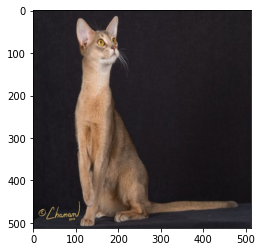

Input Image


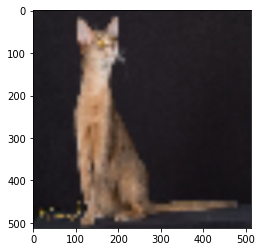

Predicted Image


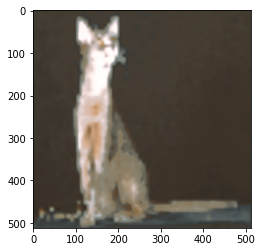

In [26]:
image_folder = "/content/IMAGE_SUPER_RESOLVE_DATA/extracted_data/images"
checkpoint_path = "/content/IMAGE_SUPER_RESOLVE_DATA/checkpoint.pt"

#PARTICULAR IMAGE
img_addr = os.path.join(image_folder, "Abyssinian_2.jpg")
img = cv2.imread(img_addr)
high_res_img = cv2.resize(img,(512,512))
low_res_img = cv2.resize(img,(64,64))
low_res_img = cv2.resize(low_res_img, (512, 512))
low_res_img = np.transpose(low_res_img, (2, 0, 1))

#CONVERTING TO FLOAT TENSOR AND INCREASE ITS DIMENSION
low_res_img = torch.FloatTensor(low_res_img/255.).unsqueeze(0)


model = Image_Super_Resolve()
model = model.to(device)
optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=0.01)
model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
low_res_img = low_res_img.to(device)
pred_img = model.forward(low_res_img)

p_img = pred_img.detach().cpu().numpy().transpose(0, 2, 3, 1)
# p_img = cv2.cvtColor(p_img, )
inp_img = low_res_img.cpu().numpy().transpose(0, 2, 3, 1)

#DISPLAYING THE GROUND TRUTH
print("Ground Truth")
plt.imshow(high_res_img[:,:,::-1])
plt.show()

#DISPLAYING THE INPUT IMAGE
print("Input Image")
plt.imshow(inp_img[0, :,:,::-1])
plt.show()

#DISPLAYING THE PREDICTED IMAGE
print("Predicted Image")
plt.imshow(p_img[0, :,:,::-1])
plt.show()